In [1]:
# %load paste_video_classification_vgg16_add_matrix.py

# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载vgg16预训练模型
model = models.vgg16(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))
# 加载上次训练的参数
# model.load_state_dict(torch.load('./parameter/params_vgg16.pth'))

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = batch_size,
                                             shuffle = shuffle,
                                             num_workers = 10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0
loss_train = [] # 训练集loss
acc_train = [] # 训练集正确率
loss_val = [] # 验证集loss
acc_val = [] # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1
                if epoch == 0:
                    best_matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1
            
            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_vgg16.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3466 Acc: 0.0000%
	train 1-2: Loss: 0.3461 Acc: 25.0000%
	train 1-3: Loss: 0.3493 Acc: 0.0000%
	train 1-4: Loss: 0.3456 Acc: 25.0000%
	train 1-5: Loss: 0.3419 Acc: 75.0000%
	train 1-6: Loss: 0.3435 Acc: 50.0000%
	train 1-7: Loss: 0.3459 Acc: 25.0000%
	train 1-8: Loss: 0.3438 Acc: 25.0000%
	train 1-9: Loss: 0.3459 Acc: 25.0000%
	train 1-10: Loss: 0.3453 Acc: 25.0000%
	train 1-11: Loss: 0.3520 Acc: 0.0000%
	train 1-12: Loss: 0.3417 Acc: 50.0000%
	train 1-13: Loss: 0.3520 Acc: 0.0000%
	train 1-14: Loss: 0.3445 Acc: 50.0000%
	train 1-15: Loss: 0.3385 Acc: 50.0000%
	train 1-16: Loss: 0.3544 Acc: 0.0000%
	train 1-17: Loss: 0.3453 Acc: 0.0000%
	train 1-18: Loss: 0.3559 Acc: 0.0000%
	train 1-19: Loss: 0.3383 Acc: 50.0000%
	train 1-20: Loss: 0.3346 Acc: 50.0000%
	train 1-21: Loss: 0.3480 Acc: 25.0000%
	train 1-22: Loss: 0.3535 Acc: 0.0000%
	train 1-23: Loss: 0.3394 Acc: 25.0000%
	train 1-24: Loss: 0.3385 Acc: 25.0000%
	train 1-25: Loss: 0.3535 Acc: 25.0000%
	tr

	train 1-205: Loss: 0.3550 Acc: 0.0000%
	train 1-206: Loss: 0.3465 Acc: 25.0000%
	train 1-207: Loss: 0.3415 Acc: 50.0000%
	train 1-208: Loss: 0.3401 Acc: 50.0000%
	train 1-209: Loss: 0.3466 Acc: 0.0000%
	train 1-210: Loss: 0.3445 Acc: 25.0000%
	train 1-211: Loss: 0.3415 Acc: 50.0000%
	train 1-212: Loss: 0.3565 Acc: 0.0000%
	train 1-213: Loss: 0.3521 Acc: 0.0000%
	train 1-214: Loss: 0.3442 Acc: 0.0000%
	train 1-215: Loss: 0.3466 Acc: 25.0000%
	train 1-216: Loss: 0.3429 Acc: 50.0000%
	train 1-217: Loss: 0.3472 Acc: 25.0000%
	train 1-218: Loss: 0.3526 Acc: 0.0000%
	train 1-219: Loss: 0.3472 Acc: 25.0000%
	train 1-220: Loss: 0.3374 Acc: 50.0000%
	train 1-221: Loss: 0.3403 Acc: 25.0000%
	train 1-222: Loss: 0.3483 Acc: 25.0000%
	train 1-223: Loss: 0.3489 Acc: 25.0000%
	train 1-224: Loss: 0.3383 Acc: 50.0000%
	train 1-225: Loss: 0.3457 Acc: 25.0000%
	train 1-226: Loss: 0.3498 Acc: 0.0000%
	train 1-227: Loss: 0.3389 Acc: 50.0000%
	train 1-228: Loss: 0.3419 Acc: 25.0000%
	train 1-229: Loss: 0.3

	train 2-46: Loss: 0.3517 Acc: 0.0000%
	train 2-47: Loss: 0.3462 Acc: 25.0000%
	train 2-48: Loss: 0.3429 Acc: 25.0000%
	train 2-49: Loss: 0.3274 Acc: 75.0000%
	train 2-50: Loss: 0.3598 Acc: 0.0000%
	train 2-51: Loss: 0.3329 Acc: 75.0000%
	train 2-52: Loss: 0.3361 Acc: 25.0000%
	train 2-53: Loss: 0.3419 Acc: 25.0000%
	train 2-54: Loss: 0.3328 Acc: 50.0000%
	train 2-55: Loss: 0.3488 Acc: 0.0000%
	train 2-56: Loss: 0.3356 Acc: 50.0000%
	train 2-57: Loss: 0.3317 Acc: 25.0000%
	train 2-58: Loss: 0.3408 Acc: 25.0000%
	train 2-59: Loss: 0.3682 Acc: 0.0000%
	train 2-60: Loss: 0.3481 Acc: 25.0000%
	train 2-61: Loss: 0.3695 Acc: 0.0000%
	train 2-62: Loss: 0.3396 Acc: 25.0000%
	train 2-63: Loss: 0.3562 Acc: 25.0000%
	train 2-64: Loss: 0.3289 Acc: 50.0000%
	train 2-65: Loss: 0.3578 Acc: 0.0000%
	train 2-66: Loss: 0.3516 Acc: 0.0000%
	train 2-67: Loss: 0.3360 Acc: 25.0000%
	train 2-68: Loss: 0.3296 Acc: 50.0000%
	train 2-69: Loss: 0.3513 Acc: 0.0000%
	train 2-70: Loss: 0.3314 Acc: 25.0000%
	train 2

	validation 2-7: Loss: 0.2991 Acc: 25.0000%
	validation 2-8: Loss: 0.2655 Acc: 25.0000%
	validation 2-9: Loss: 0.2127 Acc: 75.0000%
	validation 2-10: Loss: 0.2685 Acc: 25.0000%
	validation 2-11: Loss: 0.2886 Acc: 75.0000%
	validation 2-12: Loss: 0.2784 Acc: 25.0000%
	validation 2-13: Loss: 0.2129 Acc: 100.0000%
	validation 2-14: Loss: 0.2971 Acc: 50.0000%
	validation 2-15: Loss: 0.2972 Acc: 50.0000%
	validation 2-16: Loss: 0.1966 Acc: 75.0000%
	validation 2-17: Loss: 0.2311 Acc: 100.0000%
	validation 2-18: Loss: 0.2845 Acc: 50.0000%
	validation 2-19: Loss: 0.2705 Acc: 75.0000%
	validation 2-20: Loss: 0.3178 Acc: 25.0000%
	validation 2-21: Loss: 0.2776 Acc: 25.0000%
	validation 2-22: Loss: 0.2828 Acc: 75.0000%
	validation 2-23: Loss: 0.2689 Acc: 50.0000%
	validation 2-24: Loss: 0.2828 Acc: 50.0000%
	validation 2-25: Loss: 0.2117 Acc: 75.0000%
	validation 2-26: Loss: 0.3181 Acc: 75.0000%
	validation 2-27: Loss: 0.3343 Acc: 25.0000%
	validation 2-28: Loss: 0.2991 Acc: 50.0000%
	validation

	train 3-93: Loss: 0.3518 Acc: 25.0000%
	train 3-94: Loss: 0.3290 Acc: 50.0000%
	train 3-95: Loss: 0.3291 Acc: 50.0000%
	train 3-96: Loss: 0.3176 Acc: 75.0000%
	train 3-97: Loss: 0.3290 Acc: 50.0000%
	train 3-98: Loss: 0.3644 Acc: 0.0000%
	train 3-99: Loss: 0.3164 Acc: 75.0000%
	train 3-100: Loss: 0.3892 Acc: 25.0000%
	train 3-101: Loss: 0.3655 Acc: 25.0000%
	train 3-102: Loss: 0.3619 Acc: 25.0000%
	train 3-103: Loss: 0.3252 Acc: 25.0000%
	train 3-104: Loss: 0.2948 Acc: 75.0000%
	train 3-105: Loss: 0.3270 Acc: 25.0000%
	train 3-106: Loss: 0.3394 Acc: 25.0000%
	train 3-107: Loss: 0.3638 Acc: 0.0000%
	train 3-108: Loss: 0.3385 Acc: 25.0000%
	train 3-109: Loss: 0.4017 Acc: 25.0000%
	train 3-110: Loss: 0.3725 Acc: 25.0000%
	train 3-111: Loss: 0.3812 Acc: 0.0000%
	train 3-112: Loss: 0.4002 Acc: 0.0000%
	train 3-113: Loss: 0.3311 Acc: 50.0000%
	train 3-114: Loss: 0.3637 Acc: 0.0000%
	train 3-115: Loss: 0.3462 Acc: 0.0000%
	train 3-116: Loss: 0.3477 Acc: 25.0000%
	train 3-117: Loss: 0.3621 Ac

	validation 3-48: Loss: 0.3488 Acc: 25.0000%
	validation 3-49: Loss: 0.3499 Acc: 25.0000%
	validation 3-50: Loss: 0.3443 Acc: 25.0000%
	validation 3-51: Loss: 0.3507 Acc: 25.0000%
	validation 3-52: Loss: 0.3413 Acc: 25.0000%
	validation 3-53: Loss: 0.3394 Acc: 25.0000%
	validation 3-54: Loss: 0.3364 Acc: 50.0000%
	validation 3-55: Loss: 0.3446 Acc: 50.0000%
	validation 3-56: Loss: 0.3347 Acc: 50.0000%
	validation 3-57: Loss: 0.3520 Acc: 0.0000%
	validation 3-58: Loss: 0.3268 Acc: 50.0000%
	validation 3-59: Loss: 0.3549 Acc: 0.0000%
	validation 3-60: Loss: 0.3575 Acc: 0.0000%
	validation 3-61: Loss: 0.3417 Acc: 50.0000%
	validation 3-62: Loss: 0.3436 Acc: 50.0000%
	validation 3-63: Loss: 0.3295 Acc: 75.0000%
	validation 3-64: Loss: 0.3398 Acc: 25.0000%
	validation 3-65: Loss: 0.3485 Acc: 25.0000%
	validation 3-66: Loss: 0.3357 Acc: 50.0000%
	validation 3-67: Loss: 0.3510 Acc: 0.0000%
	validation 3-68: Loss: 0.3393 Acc: 50.0000%
	validation 3-69: Loss: 0.3497 Acc: 0.0000%
	validation 3-7

	train 4-139: Loss: 0.2300 Acc: 75.0000%
	train 4-140: Loss: 0.2650 Acc: 75.0000%
	train 4-141: Loss: 0.3181 Acc: 50.0000%
	train 4-142: Loss: 0.2454 Acc: 50.0000%
	train 4-143: Loss: 0.3107 Acc: 25.0000%
	train 4-144: Loss: 0.3490 Acc: 0.0000%
	train 4-145: Loss: 0.2471 Acc: 50.0000%
	train 4-146: Loss: 0.3208 Acc: 0.0000%
	train 4-147: Loss: 0.3236 Acc: 25.0000%
	train 4-148: Loss: 0.2101 Acc: 50.0000%
	train 4-149: Loss: 0.2351 Acc: 50.0000%
	train 4-150: Loss: 0.2715 Acc: 50.0000%
	train 4-151: Loss: 0.3606 Acc: 0.0000%
	train 4-152: Loss: 0.3313 Acc: 0.0000%
	train 4-153: Loss: 0.3293 Acc: 0.0000%
	train 4-154: Loss: 0.2418 Acc: 75.0000%
	train 4-155: Loss: 0.2554 Acc: 75.0000%
	train 4-156: Loss: 0.3222 Acc: 25.0000%
	train 4-157: Loss: 0.2957 Acc: 25.0000%
	train 4-158: Loss: 0.2444 Acc: 50.0000%
	train 4-159: Loss: 0.2637 Acc: 50.0000%
	train 4-160: Loss: 0.3235 Acc: 0.0000%
	train 4-161: Loss: 0.2906 Acc: 50.0000%
	train 4-162: Loss: 0.3302 Acc: 50.0000%
	train 4-163: Loss: 0.

	validation 4-89: Loss: 0.3514 Acc: 25.0000%
	validation 4-90: Loss: 0.3606 Acc: 0.0000%
	validation 4-91: Loss: 0.3328 Acc: 75.0000%
	validation 4-92: Loss: 0.3447 Acc: 25.0000%
	validation 4-93: Loss: 0.3594 Acc: 25.0000%
	validation 4-94: Loss: 0.3629 Acc: 25.0000%
	validation 4-95: Loss: 0.3453 Acc: 0.0000%
	validation 4-96: Loss: 0.3634 Acc: 0.0000%
	validation 4-97: Loss: 0.3502 Acc: 25.0000%
	validation 4-98: Loss: 0.3278 Acc: 25.0000%
	validation 4-99: Loss: 0.3599 Acc: 25.0000%
	validation 4-100: Loss: 0.3301 Acc: 0.0000%
	validation 4-101: Loss: 0.3653 Acc: 0.0000%
	validation 4-102: Loss: 0.3470 Acc: 50.0000%
	validation 4-103: Loss: 0.3462 Acc: 0.0000%
	validation 4-104: Loss: 0.3328 Acc: 0.0000%
	validation 4-105: Loss: 0.3705 Acc: 25.0000%
	train Loss: 0.3214 Acc: 35.7143%
	validation Loss: 0.3466 Acc: 25.0000%
Time passed 0h 3m 6s
--------------------
Epoch [5/40]:
	train 5-1: Loss: 0.3711 Acc: 0.0000%
	train 5-2: Loss: 0.3524 Acc: 25.0000%
	train 5-3: Loss: 0.3598 Acc: 

	train 5-183: Loss: 0.3348 Acc: 25.0000%
	train 5-184: Loss: 0.3589 Acc: 0.0000%
	train 5-185: Loss: 0.3271 Acc: 25.0000%
	train 5-186: Loss: 0.3521 Acc: 25.0000%
	train 5-187: Loss: 0.3341 Acc: 50.0000%
	train 5-188: Loss: 0.3245 Acc: 75.0000%
	train 5-189: Loss: 0.3306 Acc: 50.0000%
	train 5-190: Loss: 0.3826 Acc: 25.0000%
	train 5-191: Loss: 0.3997 Acc: 0.0000%
	train 5-192: Loss: 0.3760 Acc: 0.0000%
	train 5-193: Loss: 0.3242 Acc: 50.0000%
	train 5-194: Loss: 0.3371 Acc: 0.0000%
	train 5-195: Loss: 0.3207 Acc: 50.0000%
	train 5-196: Loss: 0.3380 Acc: 25.0000%
	train 5-197: Loss: 0.3205 Acc: 75.0000%
	train 5-198: Loss: 0.3510 Acc: 50.0000%
	train 5-199: Loss: 0.3338 Acc: 50.0000%
	train 5-200: Loss: 0.3286 Acc: 25.0000%
	train 5-201: Loss: 0.3446 Acc: 25.0000%
	train 5-202: Loss: 0.3267 Acc: 0.0000%
	train 5-203: Loss: 0.3613 Acc: 25.0000%
	train 5-204: Loss: 0.3389 Acc: 25.0000%
	train 5-205: Loss: 0.3162 Acc: 25.0000%
	train 5-206: Loss: 0.3281 Acc: 50.0000%
	train 5-207: Loss: 0

	train 6-20: Loss: 0.2513 Acc: 100.0000%
	train 6-21: Loss: 0.2976 Acc: 50.0000%
	train 6-22: Loss: 0.1892 Acc: 50.0000%
	train 6-23: Loss: 0.2490 Acc: 50.0000%
	train 6-24: Loss: 0.1957 Acc: 50.0000%
	train 6-25: Loss: 0.1475 Acc: 75.0000%
	train 6-26: Loss: 0.2254 Acc: 25.0000%
	train 6-27: Loss: 0.2939 Acc: 50.0000%
	train 6-28: Loss: 0.1710 Acc: 50.0000%
	train 6-29: Loss: 0.3490 Acc: 25.0000%
	train 6-30: Loss: 0.2241 Acc: 75.0000%
	train 6-31: Loss: 0.3209 Acc: 0.0000%
	train 6-32: Loss: 0.3485 Acc: 0.0000%
	train 6-33: Loss: 0.3874 Acc: 25.0000%
	train 6-34: Loss: 0.3279 Acc: 0.0000%
	train 6-35: Loss: 0.2930 Acc: 50.0000%
	train 6-36: Loss: 0.4086 Acc: 0.0000%
	train 6-37: Loss: 0.3176 Acc: 25.0000%
	train 6-38: Loss: 0.1941 Acc: 100.0000%
	train 6-39: Loss: 0.2985 Acc: 50.0000%
	train 6-40: Loss: 0.2109 Acc: 50.0000%
	train 6-41: Loss: 0.2551 Acc: 50.0000%
	train 6-42: Loss: 0.1611 Acc: 100.0000%
	train 6-43: Loss: 0.1997 Acc: 75.0000%
	train 6-44: Loss: 0.2775 Acc: 50.0000%
	

	train 6-223: Loss: 0.4091 Acc: 0.0000%
	train 6-224: Loss: 0.3507 Acc: 50.0000%
	train 6-225: Loss: 0.3246 Acc: 0.0000%
	train 6-226: Loss: 0.3208 Acc: 25.0000%
	train 6-227: Loss: 0.2893 Acc: 75.0000%
	train 6-228: Loss: 0.3104 Acc: 50.0000%
	train 6-229: Loss: 0.2912 Acc: 25.0000%
	train 6-230: Loss: 0.3133 Acc: 0.0000%
	train 6-231: Loss: 0.3531 Acc: 25.0000%
	train 6-232: Loss: 0.3293 Acc: 50.0000%
	train 6-233: Loss: 0.3089 Acc: 25.0000%
	train 6-234: Loss: 0.3218 Acc: 25.0000%
	train 6-235: Loss: 0.3101 Acc: 50.0000%
	train 6-236: Loss: 0.2854 Acc: 25.0000%
	train 6-237: Loss: 0.2801 Acc: 75.0000%
	train 6-238: Loss: 0.2923 Acc: 75.0000%
	train 6-239: Loss: 0.3367 Acc: 25.0000%
	train 6-240: Loss: 0.3001 Acc: 50.0000%
	train 6-241: Loss: 0.2326 Acc: 75.0000%
	train 6-242: Loss: 0.2741 Acc: 75.0000%
	train 6-243: Loss: 0.3191 Acc: 50.0000%
	train 6-244: Loss: 0.2857 Acc: 75.0000%
	train 6-245: Loss: 0.2176 Acc: 75.0000%
	validation 6-1: Loss: 0.2142 Acc: 75.0000%
	validation 6-2:

	train 7-63: Loss: 0.3408 Acc: 50.0000%
	train 7-64: Loss: 0.1122 Acc: 50.0000%
	train 7-65: Loss: 0.3948 Acc: 50.0000%
	train 7-66: Loss: 0.2006 Acc: 75.0000%
	train 7-67: Loss: 0.0974 Acc: 75.0000%
	train 7-68: Loss: 0.0642 Acc: 75.0000%
	train 7-69: Loss: 0.2429 Acc: 50.0000%
	train 7-70: Loss: 0.2339 Acc: 75.0000%
	train 7-71: Loss: 0.4014 Acc: 25.0000%
	train 7-72: Loss: 0.2502 Acc: 25.0000%
	train 7-73: Loss: 0.0555 Acc: 100.0000%
	train 7-74: Loss: 0.1725 Acc: 50.0000%
	train 7-75: Loss: 0.1806 Acc: 75.0000%
	train 7-76: Loss: 0.2689 Acc: 50.0000%
	train 7-77: Loss: 0.1325 Acc: 75.0000%
	train 7-78: Loss: 0.1226 Acc: 100.0000%
	train 7-79: Loss: 0.1825 Acc: 50.0000%
	train 7-80: Loss: 0.1330 Acc: 75.0000%
	train 7-81: Loss: 0.0028 Acc: 100.0000%
	train 7-82: Loss: 0.2084 Acc: 50.0000%
	train 7-83: Loss: 0.2862 Acc: 50.0000%
	train 7-84: Loss: 0.2102 Acc: 50.0000%
	train 7-85: Loss: 0.1809 Acc: 50.0000%
	train 7-86: Loss: 0.2381 Acc: 50.0000%
	train 7-87: Loss: 0.2265 Acc: 25.000

	validation 7-19: Loss: 0.1080 Acc: 50.0000%
	validation 7-20: Loss: 0.1034 Acc: 75.0000%
	validation 7-21: Loss: 0.0447 Acc: 100.0000%
	validation 7-22: Loss: 0.1074 Acc: 50.0000%
	validation 7-23: Loss: 0.0454 Acc: 100.0000%
	validation 7-24: Loss: 0.0515 Acc: 100.0000%
	validation 7-25: Loss: 0.0002 Acc: 100.0000%
	validation 7-26: Loss: 0.0539 Acc: 75.0000%
	validation 7-27: Loss: 0.0460 Acc: 100.0000%
	validation 7-28: Loss: 0.0986 Acc: 75.0000%
	validation 7-29: Loss: 0.1529 Acc: 50.0000%
	validation 7-30: Loss: 0.1833 Acc: 100.0000%
	validation 7-31: Loss: 0.0570 Acc: 75.0000%
	validation 7-32: Loss: 0.1373 Acc: 75.0000%
	validation 7-33: Loss: 0.1132 Acc: 50.0000%
	validation 7-34: Loss: 0.1128 Acc: 50.0000%
	validation 7-35: Loss: 0.0542 Acc: 75.0000%
	validation 7-36: Loss: 0.1001 Acc: 75.0000%
	validation 7-37: Loss: 0.1331 Acc: 100.0000%
	validation 7-38: Loss: 0.1002 Acc: 75.0000%
	validation 7-39: Loss: 0.1518 Acc: 50.0000%
	validation 7-40: Loss: 0.0970 Acc: 75.0000%
	va

	train 8-105: Loss: 0.0913 Acc: 75.0000%
	train 8-106: Loss: 0.2400 Acc: 25.0000%
	train 8-107: Loss: 0.0895 Acc: 75.0000%
	train 8-108: Loss: 0.1261 Acc: 50.0000%
	train 8-109: Loss: 0.1120 Acc: 50.0000%
	train 8-110: Loss: 0.0901 Acc: 75.0000%
	train 8-111: Loss: 0.2363 Acc: 50.0000%
	train 8-112: Loss: 0.2282 Acc: 75.0000%
	train 8-113: Loss: 0.1911 Acc: 50.0000%
	train 8-114: Loss: 0.0772 Acc: 75.0000%
	train 8-115: Loss: 0.0574 Acc: 75.0000%
	train 8-116: Loss: 0.1936 Acc: 50.0000%
	train 8-117: Loss: 0.0625 Acc: 75.0000%
	train 8-118: Loss: 0.0521 Acc: 100.0000%
	train 8-119: Loss: 0.1398 Acc: 50.0000%
	train 8-120: Loss: 0.3486 Acc: 25.0000%
	train 8-121: Loss: 0.1902 Acc: 25.0000%
	train 8-122: Loss: 0.0683 Acc: 75.0000%
	train 8-123: Loss: 0.2185 Acc: 50.0000%
	train 8-124: Loss: 0.1706 Acc: 50.0000%
	train 8-125: Loss: 0.1831 Acc: 75.0000%
	train 8-126: Loss: 0.1737 Acc: 75.0000%
	train 8-127: Loss: 0.2526 Acc: 0.0000%
	train 8-128: Loss: 0.1120 Acc: 100.0000%
	train 8-129: L

	validation 8-59: Loss: 0.0785 Acc: 100.0000%
	validation 8-60: Loss: 0.1172 Acc: 75.0000%
	validation 8-61: Loss: 0.0884 Acc: 75.0000%
	validation 8-62: Loss: 0.1279 Acc: 75.0000%
	validation 8-63: Loss: 0.0882 Acc: 100.0000%
	validation 8-64: Loss: 0.1314 Acc: 75.0000%
	validation 8-65: Loss: 0.0416 Acc: 100.0000%
	validation 8-66: Loss: 0.0451 Acc: 75.0000%
	validation 8-67: Loss: 0.0956 Acc: 50.0000%
	validation 8-68: Loss: 0.0824 Acc: 100.0000%
	validation 8-69: Loss: 0.0861 Acc: 75.0000%
	validation 8-70: Loss: 0.0809 Acc: 100.0000%
	validation 8-71: Loss: 0.0409 Acc: 100.0000%
	validation 8-72: Loss: 0.0482 Acc: 75.0000%
	validation 8-73: Loss: 0.1374 Acc: 50.0000%
	validation 8-74: Loss: 0.0891 Acc: 75.0000%
	validation 8-75: Loss: 0.0892 Acc: 75.0000%
	validation 8-76: Loss: 0.1288 Acc: 75.0000%
	validation 8-77: Loss: 0.0877 Acc: 75.0000%
	validation 8-78: Loss: 0.1738 Acc: 75.0000%
	validation 8-79: Loss: 0.0020 Acc: 100.0000%
	validation 8-80: Loss: 0.1235 Acc: 100.0000%
	v

	train 9-149: Loss: 0.0482 Acc: 100.0000%
	train 9-150: Loss: 0.1654 Acc: 50.0000%
	train 9-151: Loss: 0.1715 Acc: 75.0000%
	train 9-152: Loss: 0.1033 Acc: 75.0000%
	train 9-153: Loss: 0.1247 Acc: 50.0000%
	train 9-154: Loss: 0.0941 Acc: 100.0000%
	train 9-155: Loss: 0.0359 Acc: 100.0000%
	train 9-156: Loss: 0.0141 Acc: 100.0000%
	train 9-157: Loss: 0.2133 Acc: 50.0000%
	train 9-158: Loss: 0.2880 Acc: 0.0000%
	train 9-159: Loss: 0.0895 Acc: 75.0000%
	train 9-160: Loss: 0.0000 Acc: 100.0000%
	train 9-161: Loss: 0.1238 Acc: 100.0000%
	train 9-162: Loss: 0.2260 Acc: 50.0000%
	train 9-163: Loss: 0.1418 Acc: 50.0000%
	train 9-164: Loss: 0.0986 Acc: 75.0000%
	train 9-165: Loss: 0.1073 Acc: 50.0000%
	train 9-166: Loss: 0.2704 Acc: 0.0000%
	train 9-167: Loss: 0.1205 Acc: 100.0000%
	train 9-168: Loss: 0.1780 Acc: 50.0000%
	train 9-169: Loss: 0.2162 Acc: 50.0000%
	train 9-170: Loss: 0.2490 Acc: 75.0000%
	train 9-171: Loss: 0.0813 Acc: 75.0000%
	train 9-172: Loss: 0.0640 Acc: 100.0000%
	train 9-1

	validation 9-94: Loss: 0.0392 Acc: 100.0000%
	validation 9-95: Loss: 0.1364 Acc: 50.0000%
	validation 9-96: Loss: 0.0400 Acc: 100.0000%
	validation 9-97: Loss: 0.0522 Acc: 75.0000%
	validation 9-98: Loss: 0.1297 Acc: 75.0000%
	validation 9-99: Loss: 0.1016 Acc: 75.0000%
	validation 9-100: Loss: 0.0783 Acc: 100.0000%
	validation 9-101: Loss: 0.1492 Acc: 25.0000%
	validation 9-102: Loss: 0.0373 Acc: 100.0000%
	validation 9-103: Loss: 0.0815 Acc: 100.0000%
	validation 9-104: Loss: 0.0948 Acc: 50.0000%
	validation 9-105: Loss: 0.1006 Acc: 50.0000%
	train Loss: 0.1441 Acc: 68.5714%
	validation Loss: 0.0906 Acc: 75.9524%
网络参数更新
Time passed 0h 7m 3s
--------------------
Epoch [10/40]:
	train 10-1: Loss: 0.0856 Acc: 75.0000%
	train 10-2: Loss: 0.1368 Acc: 50.0000%
	train 10-3: Loss: 0.1299 Acc: 75.0000%
	train 10-4: Loss: 0.0451 Acc: 100.0000%
	train 10-5: Loss: 0.2126 Acc: 50.0000%
	train 10-6: Loss: 0.0840 Acc: 100.0000%
	train 10-7: Loss: 0.2322 Acc: 75.0000%
	train 10-8: Loss: 0.0918 Acc:

	train 10-181: Loss: 0.0374 Acc: 100.0000%
	train 10-182: Loss: 0.0864 Acc: 100.0000%
	train 10-183: Loss: 0.0534 Acc: 75.0000%
	train 10-184: Loss: 0.1514 Acc: 50.0000%
	train 10-185: Loss: 0.0773 Acc: 100.0000%
	train 10-186: Loss: 0.0956 Acc: 75.0000%
	train 10-187: Loss: 0.0866 Acc: 75.0000%
	train 10-188: Loss: 0.0523 Acc: 100.0000%
	train 10-189: Loss: 0.0726 Acc: 100.0000%
	train 10-190: Loss: 0.1167 Acc: 100.0000%
	train 10-191: Loss: 0.0881 Acc: 75.0000%
	train 10-192: Loss: 0.1038 Acc: 75.0000%
	train 10-193: Loss: 0.1485 Acc: 75.0000%
	train 10-194: Loss: 0.0368 Acc: 100.0000%
	train 10-195: Loss: 0.2031 Acc: 50.0000%
	train 10-196: Loss: 0.1491 Acc: 75.0000%
	train 10-197: Loss: 0.1561 Acc: 75.0000%
	train 10-198: Loss: 0.1024 Acc: 75.0000%
	train 10-199: Loss: 0.0401 Acc: 100.0000%
	train 10-200: Loss: 0.0519 Acc: 75.0000%
	train 10-201: Loss: 0.1022 Acc: 75.0000%
	train 10-202: Loss: 0.1378 Acc: 75.0000%
	train 10-203: Loss: 0.1287 Acc: 75.0000%
	train 10-204: Loss: 0.046

	train 11-14: Loss: 0.2421 Acc: 25.0000%
	train 11-15: Loss: 0.2274 Acc: 25.0000%
	train 11-16: Loss: 0.1683 Acc: 75.0000%
	train 11-17: Loss: 0.2979 Acc: 25.0000%
	train 11-18: Loss: 0.1831 Acc: 50.0000%
	train 11-19: Loss: 0.2200 Acc: 75.0000%
	train 11-20: Loss: 0.1601 Acc: 75.0000%
	train 11-21: Loss: 0.1918 Acc: 50.0000%
	train 11-22: Loss: 0.1741 Acc: 50.0000%
	train 11-23: Loss: 0.2224 Acc: 50.0000%
	train 11-24: Loss: 0.1368 Acc: 50.0000%
	train 11-25: Loss: 0.2328 Acc: 50.0000%
	train 11-26: Loss: 0.1882 Acc: 50.0000%
	train 11-27: Loss: 0.3099 Acc: 25.0000%
	train 11-28: Loss: 0.0974 Acc: 100.0000%
	train 11-29: Loss: 0.2307 Acc: 75.0000%
	train 11-30: Loss: 0.2516 Acc: 50.0000%
	train 11-31: Loss: 0.1332 Acc: 75.0000%
	train 11-32: Loss: 0.3648 Acc: 0.0000%
	train 11-33: Loss: 0.1569 Acc: 50.0000%
	train 11-34: Loss: 0.2378 Acc: 25.0000%
	train 11-35: Loss: 0.0725 Acc: 75.0000%
	train 11-36: Loss: 0.1427 Acc: 50.0000%
	train 11-37: Loss: 0.1512 Acc: 75.0000%
	train 11-38: Lo

	train 11-211: Loss: 0.0584 Acc: 75.0000%
	train 11-212: Loss: 0.0000 Acc: 100.0000%
	train 11-213: Loss: 0.0467 Acc: 75.0000%
	train 11-214: Loss: 0.0267 Acc: 100.0000%
	train 11-215: Loss: 0.1168 Acc: 75.0000%
	train 11-216: Loss: 0.0411 Acc: 100.0000%
	train 11-217: Loss: 0.1589 Acc: 50.0000%
	train 11-218: Loss: 0.0378 Acc: 100.0000%
	train 11-219: Loss: 0.2332 Acc: 25.0000%
	train 11-220: Loss: 0.0264 Acc: 100.0000%
	train 11-221: Loss: 0.3791 Acc: 50.0000%
	train 11-222: Loss: 0.0732 Acc: 100.0000%
	train 11-223: Loss: 0.1970 Acc: 25.0000%
	train 11-224: Loss: 0.1298 Acc: 50.0000%
	train 11-225: Loss: 0.1704 Acc: 75.0000%
	train 11-226: Loss: 0.1459 Acc: 75.0000%
	train 11-227: Loss: 0.0512 Acc: 75.0000%
	train 11-228: Loss: 0.2120 Acc: 25.0000%
	train 11-229: Loss: 0.1254 Acc: 100.0000%
	train 11-230: Loss: 0.0603 Acc: 75.0000%
	train 11-231: Loss: 0.0821 Acc: 75.0000%
	train 11-232: Loss: 0.0657 Acc: 75.0000%
	train 11-233: Loss: 0.1142 Acc: 50.0000%
	train 11-234: Loss: 0.0944

	train 12-43: Loss: 0.2608 Acc: 75.0000%
	train 12-44: Loss: 0.0714 Acc: 100.0000%
	train 12-45: Loss: 0.0903 Acc: 100.0000%
	train 12-46: Loss: 0.0001 Acc: 100.0000%
	train 12-47: Loss: 0.1485 Acc: 50.0000%
	train 12-48: Loss: 0.0990 Acc: 75.0000%
	train 12-49: Loss: 0.1193 Acc: 75.0000%
	train 12-50: Loss: 0.0274 Acc: 100.0000%
	train 12-51: Loss: 0.1789 Acc: 75.0000%
	train 12-52: Loss: 0.1026 Acc: 75.0000%
	train 12-53: Loss: 0.1233 Acc: 75.0000%
	train 12-54: Loss: 0.2161 Acc: 25.0000%
	train 12-55: Loss: 0.1101 Acc: 50.0000%
	train 12-56: Loss: 0.1692 Acc: 25.0000%
	train 12-57: Loss: 0.0938 Acc: 75.0000%
	train 12-58: Loss: 0.0848 Acc: 100.0000%
	train 12-59: Loss: 0.0482 Acc: 100.0000%
	train 12-60: Loss: 0.0450 Acc: 100.0000%
	train 12-61: Loss: 0.1088 Acc: 50.0000%
	train 12-62: Loss: 0.3787 Acc: 25.0000%
	train 12-63: Loss: 0.0935 Acc: 75.0000%
	train 12-64: Loss: 0.1003 Acc: 75.0000%
	train 12-65: Loss: 0.1126 Acc: 75.0000%
	train 12-66: Loss: 0.3965 Acc: 50.0000%
	train 12

	train 12-240: Loss: 0.1489 Acc: 75.0000%
	train 12-241: Loss: 0.1199 Acc: 50.0000%
	train 12-242: Loss: 0.0943 Acc: 75.0000%
	train 12-243: Loss: 0.1143 Acc: 75.0000%
	train 12-244: Loss: 0.0969 Acc: 75.0000%
	train 12-245: Loss: 0.1008 Acc: 100.0000%
	validation 12-1: Loss: 0.1360 Acc: 75.0000%
	validation 12-2: Loss: 0.1369 Acc: 75.0000%
	validation 12-3: Loss: 0.1028 Acc: 50.0000%
	validation 12-4: Loss: 0.1346 Acc: 50.0000%
	validation 12-5: Loss: 0.2617 Acc: 50.0000%
	validation 12-6: Loss: 0.0401 Acc: 100.0000%
	validation 12-7: Loss: 0.1315 Acc: 75.0000%
	validation 12-8: Loss: 0.1045 Acc: 50.0000%
	validation 12-9: Loss: 0.0526 Acc: 75.0000%
	validation 12-10: Loss: 0.0373 Acc: 100.0000%
	validation 12-11: Loss: 0.1697 Acc: 75.0000%
	validation 12-12: Loss: 0.0459 Acc: 100.0000%
	validation 12-13: Loss: 0.1493 Acc: 50.0000%
	validation 12-14: Loss: 0.0877 Acc: 75.0000%
	validation 12-15: Loss: 0.0809 Acc: 100.0000%
	validation 12-16: Loss: 0.1429 Acc: 50.0000%
	validation 12-1

	train 13-73: Loss: 0.0992 Acc: 75.0000%
	train 13-74: Loss: 0.0666 Acc: 75.0000%
	train 13-75: Loss: 0.0342 Acc: 100.0000%
	train 13-76: Loss: 0.0916 Acc: 75.0000%
	train 13-77: Loss: 0.0621 Acc: 75.0000%
	train 13-78: Loss: 0.0881 Acc: 75.0000%
	train 13-79: Loss: 0.1402 Acc: 50.0000%
	train 13-80: Loss: 0.1053 Acc: 100.0000%
	train 13-81: Loss: 0.1461 Acc: 50.0000%
	train 13-82: Loss: 0.0694 Acc: 100.0000%
	train 13-83: Loss: 0.1708 Acc: 75.0000%
	train 13-84: Loss: 0.0732 Acc: 100.0000%
	train 13-85: Loss: 0.1384 Acc: 50.0000%
	train 13-86: Loss: 0.1460 Acc: 75.0000%
	train 13-87: Loss: 0.0086 Acc: 100.0000%
	train 13-88: Loss: 0.1873 Acc: 25.0000%
	train 13-89: Loss: 0.0465 Acc: 100.0000%
	train 13-90: Loss: 0.2138 Acc: 25.0000%
	train 13-91: Loss: 0.1336 Acc: 50.0000%
	train 13-92: Loss: 0.0917 Acc: 100.0000%
	train 13-93: Loss: 0.1232 Acc: 100.0000%
	train 13-94: Loss: 0.0052 Acc: 100.0000%
	train 13-95: Loss: 0.1935 Acc: 75.0000%
	train 13-96: Loss: 0.1420 Acc: 75.0000%
	train 

	validation 13-21: Loss: 0.0764 Acc: 100.0000%
	validation 13-22: Loss: 0.1042 Acc: 75.0000%
	validation 13-23: Loss: 0.0892 Acc: 75.0000%
	validation 13-24: Loss: 0.0365 Acc: 100.0000%
	validation 13-25: Loss: 0.1117 Acc: 75.0000%
	validation 13-26: Loss: 0.1376 Acc: 50.0000%
	validation 13-27: Loss: 0.1434 Acc: 50.0000%
	validation 13-28: Loss: 0.1975 Acc: 50.0000%
	validation 13-29: Loss: 0.0555 Acc: 75.0000%
	validation 13-30: Loss: 0.0000 Acc: 100.0000%
	validation 13-31: Loss: 0.4261 Acc: 50.0000%
	validation 13-32: Loss: 0.0764 Acc: 100.0000%
	validation 13-33: Loss: 0.4142 Acc: 50.0000%
	validation 13-34: Loss: 0.0871 Acc: 100.0000%
	validation 13-35: Loss: 0.0783 Acc: 100.0000%
	validation 13-36: Loss: 0.1027 Acc: 50.0000%
	validation 13-37: Loss: 0.4996 Acc: 50.0000%
	validation 13-38: Loss: 0.6090 Acc: 50.0000%
	validation 13-39: Loss: 0.0608 Acc: 75.0000%
	validation 13-40: Loss: 0.0892 Acc: 75.0000%
	validation 13-41: Loss: 0.0904 Acc: 75.0000%
	validation 13-42: Loss: 0.0

	train 14-101: Loss: 0.0356 Acc: 100.0000%
	train 14-102: Loss: 0.2421 Acc: 75.0000%
	train 14-103: Loss: 0.1203 Acc: 75.0000%
	train 14-104: Loss: 0.1642 Acc: 25.0000%
	train 14-105: Loss: 0.3009 Acc: 25.0000%
	train 14-106: Loss: 0.1099 Acc: 75.0000%
	train 14-107: Loss: 0.1594 Acc: 75.0000%
	train 14-108: Loss: 0.0442 Acc: 100.0000%
	train 14-109: Loss: 0.1010 Acc: 75.0000%
	train 14-110: Loss: 0.1078 Acc: 75.0000%
	train 14-111: Loss: 0.1344 Acc: 50.0000%
	train 14-112: Loss: 0.1419 Acc: 50.0000%
	train 14-113: Loss: 0.0453 Acc: 100.0000%
	train 14-114: Loss: 0.1769 Acc: 75.0000%
	train 14-115: Loss: 0.0896 Acc: 100.0000%
	train 14-116: Loss: 0.1372 Acc: 50.0000%
	train 14-117: Loss: 0.1271 Acc: 50.0000%
	train 14-118: Loss: 0.1434 Acc: 75.0000%
	train 14-119: Loss: 0.0859 Acc: 100.0000%
	train 14-120: Loss: 0.0901 Acc: 75.0000%
	train 14-121: Loss: 0.1380 Acc: 50.0000%
	train 14-122: Loss: 0.0539 Acc: 75.0000%
	train 14-123: Loss: 0.0782 Acc: 75.0000%
	train 14-124: Loss: 0.1338 A

	validation 14-50: Loss: 0.1631 Acc: 50.0000%
	validation 14-51: Loss: 0.0725 Acc: 75.0000%
	validation 14-52: Loss: 0.0603 Acc: 75.0000%
	validation 14-53: Loss: 0.1299 Acc: 75.0000%
	validation 14-54: Loss: 0.0286 Acc: 100.0000%
	validation 14-55: Loss: 0.0673 Acc: 100.0000%
	validation 14-56: Loss: 0.0626 Acc: 100.0000%
	validation 14-57: Loss: 0.0689 Acc: 75.0000%
	validation 14-58: Loss: 0.1829 Acc: 50.0000%
	validation 14-59: Loss: 0.0778 Acc: 75.0000%
	validation 14-60: Loss: 0.0910 Acc: 100.0000%
	validation 14-61: Loss: 0.0936 Acc: 75.0000%
	validation 14-62: Loss: 0.1597 Acc: 50.0000%
	validation 14-63: Loss: 0.1576 Acc: 75.0000%
	validation 14-64: Loss: 0.1271 Acc: 75.0000%
	validation 14-65: Loss: 0.0596 Acc: 100.0000%
	validation 14-66: Loss: 0.0255 Acc: 100.0000%
	validation 14-67: Loss: 0.1906 Acc: 50.0000%
	validation 14-68: Loss: 0.1095 Acc: 75.0000%
	validation 14-69: Loss: 0.0681 Acc: 75.0000%
	validation 14-70: Loss: 0.0770 Acc: 75.0000%
	validation 14-71: Loss: 0.0

	train 15-133: Loss: 0.1495 Acc: 50.0000%
	train 15-134: Loss: 0.1065 Acc: 50.0000%
	train 15-135: Loss: 0.1538 Acc: 50.0000%
	train 15-136: Loss: 0.0977 Acc: 75.0000%
	train 15-137: Loss: 0.0436 Acc: 100.0000%
	train 15-138: Loss: 0.1515 Acc: 75.0000%
	train 15-139: Loss: 0.0892 Acc: 75.0000%
	train 15-140: Loss: 0.1630 Acc: 50.0000%
	train 15-141: Loss: 0.0679 Acc: 100.0000%
	train 15-142: Loss: 0.1356 Acc: 75.0000%
	train 15-143: Loss: 0.0946 Acc: 75.0000%
	train 15-144: Loss: 0.0758 Acc: 100.0000%
	train 15-145: Loss: 0.0728 Acc: 75.0000%
	train 15-146: Loss: 0.1217 Acc: 75.0000%
	train 15-147: Loss: 0.1932 Acc: 25.0000%
	train 15-148: Loss: 0.0538 Acc: 75.0000%
	train 15-149: Loss: 0.0392 Acc: 100.0000%
	train 15-150: Loss: 0.0945 Acc: 75.0000%
	train 15-151: Loss: 0.0433 Acc: 100.0000%
	train 15-152: Loss: 0.0563 Acc: 75.0000%
	train 15-153: Loss: 0.0732 Acc: 100.0000%
	train 15-154: Loss: 0.0970 Acc: 50.0000%
	train 15-155: Loss: 0.1443 Acc: 50.0000%
	train 15-156: Loss: 0.0812 

	validation 15-76: Loss: 0.1734 Acc: 100.0000%
	validation 15-77: Loss: 0.0941 Acc: 75.0000%
	validation 15-78: Loss: 0.1855 Acc: 25.0000%
	validation 15-79: Loss: 0.1235 Acc: 100.0000%
	validation 15-80: Loss: 0.1266 Acc: 75.0000%
	validation 15-81: Loss: 0.0429 Acc: 100.0000%
	validation 15-82: Loss: 0.1819 Acc: 50.0000%
	validation 15-83: Loss: 0.0556 Acc: 75.0000%
	validation 15-84: Loss: 0.0853 Acc: 100.0000%
	validation 15-85: Loss: 0.0855 Acc: 100.0000%
	validation 15-86: Loss: 0.0458 Acc: 75.0000%
	validation 15-87: Loss: 0.0854 Acc: 100.0000%
	validation 15-88: Loss: 0.0910 Acc: 75.0000%
	validation 15-89: Loss: 0.0000 Acc: 100.0000%
	validation 15-90: Loss: 0.0894 Acc: 75.0000%
	validation 15-91: Loss: 0.0952 Acc: 50.0000%
	validation 15-92: Loss: 0.0918 Acc: 75.0000%
	validation 15-93: Loss: 0.0297 Acc: 100.0000%
	validation 15-94: Loss: 0.1181 Acc: 75.0000%
	validation 15-95: Loss: 0.0868 Acc: 100.0000%
	validation 15-96: Loss: 0.0000 Acc: 100.0000%
	validation 15-97: Loss:

	train 16-161: Loss: 0.1877 Acc: 75.0000%
	train 16-162: Loss: 0.1283 Acc: 75.0000%
	train 16-163: Loss: 0.1428 Acc: 50.0000%
	train 16-164: Loss: 0.1334 Acc: 50.0000%
	train 16-165: Loss: 0.2429 Acc: 25.0000%
	train 16-166: Loss: 0.1291 Acc: 75.0000%
	train 16-167: Loss: 0.2799 Acc: 25.0000%
	train 16-168: Loss: 0.0949 Acc: 75.0000%
	train 16-169: Loss: 0.1430 Acc: 75.0000%
	train 16-170: Loss: 0.1440 Acc: 50.0000%
	train 16-171: Loss: 0.2725 Acc: 75.0000%
	train 16-172: Loss: 0.0982 Acc: 75.0000%
	train 16-173: Loss: 0.1304 Acc: 75.0000%
	train 16-174: Loss: 0.1650 Acc: 75.0000%
	train 16-175: Loss: 0.0833 Acc: 100.0000%
	train 16-176: Loss: 0.0986 Acc: 75.0000%
	train 16-177: Loss: 0.1208 Acc: 50.0000%
	train 16-178: Loss: 0.0617 Acc: 100.0000%
	train 16-179: Loss: 0.1809 Acc: 75.0000%
	train 16-180: Loss: 0.0943 Acc: 100.0000%
	train 16-181: Loss: 0.0835 Acc: 100.0000%
	train 16-182: Loss: 0.1200 Acc: 75.0000%
	train 16-183: Loss: 0.2149 Acc: 50.0000%
	train 16-184: Loss: 0.1524 Ac

	validation 16-101: Loss: 0.0951 Acc: 50.0000%
	validation 16-102: Loss: 0.1421 Acc: 100.0000%
	validation 16-103: Loss: 0.0872 Acc: 100.0000%
	validation 16-104: Loss: 0.0024 Acc: 100.0000%
	validation 16-105: Loss: 0.0002 Acc: 100.0000%
	train Loss: 0.1209 Acc: 73.1633%
	validation Loss: 0.0901 Acc: 85.0000%
网络参数更新
Time passed 0h 12m 30s
--------------------
Epoch [17/40]:
	train 17-1: Loss: 0.0486 Acc: 75.0000%
	train 17-2: Loss: 0.0132 Acc: 100.0000%
	train 17-3: Loss: 0.0428 Acc: 100.0000%
	train 17-4: Loss: 0.1716 Acc: 50.0000%
	train 17-5: Loss: 0.1504 Acc: 50.0000%
	train 17-6: Loss: 0.1011 Acc: 50.0000%
	train 17-7: Loss: 0.1357 Acc: 50.0000%
	train 17-8: Loss: 0.1877 Acc: 75.0000%
	train 17-9: Loss: 0.2162 Acc: 50.0000%
	train 17-10: Loss: 0.1353 Acc: 75.0000%
	train 17-11: Loss: 0.0426 Acc: 100.0000%
	train 17-12: Loss: 0.0817 Acc: 100.0000%
	train 17-13: Loss: 0.0748 Acc: 75.0000%
	train 17-14: Loss: 0.0835 Acc: 75.0000%
	train 17-15: Loss: 0.1063 Acc: 100.0000%
	train 17-1

	train 17-190: Loss: 0.0474 Acc: 75.0000%
	train 17-191: Loss: 0.0472 Acc: 75.0000%
	train 17-192: Loss: 0.0476 Acc: 100.0000%
	train 17-193: Loss: 0.0625 Acc: 100.0000%
	train 17-194: Loss: 0.2257 Acc: 25.0000%
	train 17-195: Loss: 0.0416 Acc: 100.0000%
	train 17-196: Loss: 0.0380 Acc: 100.0000%
	train 17-197: Loss: 0.1275 Acc: 50.0000%
	train 17-198: Loss: 0.1714 Acc: 50.0000%
	train 17-199: Loss: 0.1198 Acc: 50.0000%
	train 17-200: Loss: 0.0318 Acc: 100.0000%
	train 17-201: Loss: 0.1524 Acc: 75.0000%
	train 17-202: Loss: 0.1054 Acc: 75.0000%
	train 17-203: Loss: 0.0572 Acc: 75.0000%
	train 17-204: Loss: 0.0219 Acc: 100.0000%
	train 17-205: Loss: 0.0176 Acc: 100.0000%
	train 17-206: Loss: 0.0208 Acc: 100.0000%
	train 17-207: Loss: 0.1752 Acc: 50.0000%
	train 17-208: Loss: 0.0702 Acc: 100.0000%
	train 17-209: Loss: 0.1369 Acc: 100.0000%
	train 17-210: Loss: 0.1557 Acc: 50.0000%
	train 17-211: Loss: 0.0836 Acc: 75.0000%
	train 17-212: Loss: 0.0477 Acc: 100.0000%
	train 17-213: Loss: 0.

	train 18-23: Loss: 0.0324 Acc: 100.0000%
	train 18-24: Loss: 0.0446 Acc: 100.0000%
	train 18-25: Loss: 0.0158 Acc: 100.0000%
	train 18-26: Loss: 0.1620 Acc: 75.0000%
	train 18-27: Loss: 0.0523 Acc: 100.0000%
	train 18-28: Loss: 0.1339 Acc: 50.0000%
	train 18-29: Loss: 0.0579 Acc: 75.0000%
	train 18-30: Loss: 0.1037 Acc: 75.0000%
	train 18-31: Loss: 0.0849 Acc: 75.0000%
	train 18-32: Loss: 0.0350 Acc: 100.0000%
	train 18-33: Loss: 0.1471 Acc: 75.0000%
	train 18-34: Loss: 0.1342 Acc: 50.0000%
	train 18-35: Loss: 0.1025 Acc: 75.0000%
	train 18-36: Loss: 0.0770 Acc: 100.0000%
	train 18-37: Loss: 0.0851 Acc: 100.0000%
	train 18-38: Loss: 0.1143 Acc: 75.0000%
	train 18-39: Loss: 0.0331 Acc: 100.0000%
	train 18-40: Loss: 0.1461 Acc: 50.0000%
	train 18-41: Loss: 0.0689 Acc: 75.0000%
	train 18-42: Loss: 0.0771 Acc: 100.0000%
	train 18-43: Loss: 0.0390 Acc: 100.0000%
	train 18-44: Loss: 0.1402 Acc: 50.0000%
	train 18-45: Loss: 0.1130 Acc: 50.0000%
	train 18-46: Loss: 0.1076 Acc: 50.0000%
	train

	train 18-220: Loss: 0.0998 Acc: 75.0000%
	train 18-221: Loss: 0.0776 Acc: 100.0000%
	train 18-222: Loss: 0.0973 Acc: 75.0000%
	train 18-223: Loss: 0.0533 Acc: 75.0000%
	train 18-224: Loss: 0.0784 Acc: 75.0000%
	train 18-225: Loss: 0.1944 Acc: 50.0000%
	train 18-226: Loss: 0.1311 Acc: 50.0000%
	train 18-227: Loss: 0.1047 Acc: 100.0000%
	train 18-228: Loss: 0.1349 Acc: 75.0000%
	train 18-229: Loss: 0.1232 Acc: 75.0000%
	train 18-230: Loss: 0.0798 Acc: 75.0000%
	train 18-231: Loss: 0.0208 Acc: 100.0000%
	train 18-232: Loss: 0.0508 Acc: 75.0000%
	train 18-233: Loss: 0.1042 Acc: 75.0000%
	train 18-234: Loss: 0.1410 Acc: 75.0000%
	train 18-235: Loss: 0.0763 Acc: 75.0000%
	train 18-236: Loss: 0.0577 Acc: 75.0000%
	train 18-237: Loss: 0.0429 Acc: 100.0000%
	train 18-238: Loss: 0.0952 Acc: 50.0000%
	train 18-239: Loss: 0.1008 Acc: 75.0000%
	train 18-240: Loss: 0.0349 Acc: 100.0000%
	train 18-241: Loss: 0.1510 Acc: 75.0000%
	train 18-242: Loss: 0.1475 Acc: 50.0000%
	train 18-243: Loss: 0.2484 A

	train 19-52: Loss: 0.0649 Acc: 75.0000%
	train 19-53: Loss: 0.1449 Acc: 75.0000%
	train 19-54: Loss: 0.0435 Acc: 100.0000%
	train 19-55: Loss: 0.1353 Acc: 100.0000%
	train 19-56: Loss: 0.0812 Acc: 100.0000%
	train 19-57: Loss: 0.0150 Acc: 100.0000%
	train 19-58: Loss: 0.1997 Acc: 50.0000%
	train 19-59: Loss: 0.1610 Acc: 50.0000%
	train 19-60: Loss: 0.0743 Acc: 100.0000%
	train 19-61: Loss: 0.0411 Acc: 100.0000%
	train 19-62: Loss: 0.0408 Acc: 100.0000%
	train 19-63: Loss: 0.1478 Acc: 75.0000%
	train 19-64: Loss: 0.3190 Acc: 75.0000%
	train 19-65: Loss: 0.1285 Acc: 75.0000%
	train 19-66: Loss: 0.0601 Acc: 100.0000%
	train 19-67: Loss: 0.1234 Acc: 50.0000%
	train 19-68: Loss: 0.0371 Acc: 100.0000%
	train 19-69: Loss: 0.0900 Acc: 75.0000%
	train 19-70: Loss: 0.2209 Acc: 25.0000%
	train 19-71: Loss: 0.0001 Acc: 100.0000%
	train 19-72: Loss: 0.1090 Acc: 75.0000%
	train 19-73: Loss: 0.1771 Acc: 50.0000%
	train 19-74: Loss: 0.0773 Acc: 100.0000%
	train 19-75: Loss: 0.2230 Acc: 75.0000%
	trai

	validation 19-8: Loss: 0.0284 Acc: 100.0000%
	validation 19-9: Loss: 0.0775 Acc: 100.0000%
	validation 19-10: Loss: 0.0246 Acc: 100.0000%
	validation 19-11: Loss: 0.0382 Acc: 100.0000%
	validation 19-12: Loss: 0.0729 Acc: 75.0000%
	validation 19-13: Loss: 0.0394 Acc: 100.0000%
	validation 19-14: Loss: 0.0644 Acc: 100.0000%
	validation 19-15: Loss: 0.0646 Acc: 100.0000%
	validation 19-16: Loss: 0.0336 Acc: 100.0000%
	validation 19-17: Loss: 0.0663 Acc: 100.0000%
	validation 19-18: Loss: 0.1194 Acc: 75.0000%
	validation 19-19: Loss: 0.0959 Acc: 100.0000%
	validation 19-20: Loss: 0.0269 Acc: 100.0000%
	validation 19-21: Loss: 0.0224 Acc: 100.0000%
	validation 19-22: Loss: 0.1034 Acc: 75.0000%
	validation 19-23: Loss: 0.0510 Acc: 100.0000%
	validation 19-24: Loss: 0.0000 Acc: 100.0000%
	validation 19-25: Loss: 0.1434 Acc: 75.0000%
	validation 19-26: Loss: 0.0407 Acc: 100.0000%
	validation 19-27: Loss: 0.0622 Acc: 100.0000%
	validation 19-28: Loss: 0.0578 Acc: 100.0000%
	validation 19-29: 

	train 20-86: Loss: 0.0895 Acc: 75.0000%
	train 20-87: Loss: 0.0592 Acc: 75.0000%
	train 20-88: Loss: 0.0623 Acc: 75.0000%
	train 20-89: Loss: 0.1019 Acc: 75.0000%
	train 20-90: Loss: 0.0210 Acc: 100.0000%
	train 20-91: Loss: 0.0780 Acc: 100.0000%
	train 20-92: Loss: 0.0440 Acc: 100.0000%
	train 20-93: Loss: 0.0652 Acc: 100.0000%
	train 20-94: Loss: 0.0404 Acc: 100.0000%
	train 20-95: Loss: 0.0646 Acc: 100.0000%
	train 20-96: Loss: 0.0682 Acc: 100.0000%
	train 20-97: Loss: 0.2765 Acc: 50.0000%
	train 20-98: Loss: 0.0439 Acc: 100.0000%
	train 20-99: Loss: 0.1163 Acc: 50.0000%
	train 20-100: Loss: 0.1050 Acc: 75.0000%
	train 20-101: Loss: 0.2710 Acc: 75.0000%
	train 20-102: Loss: 0.0207 Acc: 100.0000%
	train 20-103: Loss: 0.2007 Acc: 50.0000%
	train 20-104: Loss: 0.1296 Acc: 75.0000%
	train 20-105: Loss: 0.1100 Acc: 75.0000%
	train 20-106: Loss: 0.0802 Acc: 100.0000%
	train 20-107: Loss: 0.0675 Acc: 75.0000%
	train 20-108: Loss: 0.0627 Acc: 75.0000%
	train 20-109: Loss: 0.0859 Acc: 75.00

	validation 20-38: Loss: 0.0619 Acc: 75.0000%
	validation 20-39: Loss: 0.0163 Acc: 100.0000%
	validation 20-40: Loss: 0.0490 Acc: 75.0000%
	validation 20-41: Loss: 0.1266 Acc: 75.0000%
	validation 20-42: Loss: 0.1313 Acc: 75.0000%
	validation 20-43: Loss: 0.1225 Acc: 75.0000%
	validation 20-44: Loss: 0.0756 Acc: 75.0000%
	validation 20-45: Loss: 0.1439 Acc: 50.0000%
	validation 20-46: Loss: 0.1613 Acc: 75.0000%
	validation 20-47: Loss: 0.1006 Acc: 75.0000%
	validation 20-48: Loss: 0.0463 Acc: 100.0000%
	validation 20-49: Loss: 0.0621 Acc: 100.0000%
	validation 20-50: Loss: 0.0141 Acc: 100.0000%
	validation 20-51: Loss: 0.1644 Acc: 50.0000%
	validation 20-52: Loss: 0.0004 Acc: 100.0000%
	validation 20-53: Loss: 0.1912 Acc: 25.0000%
	validation 20-54: Loss: 0.0373 Acc: 100.0000%
	validation 20-55: Loss: 0.1377 Acc: 75.0000%
	validation 20-56: Loss: 0.0442 Acc: 100.0000%
	validation 20-57: Loss: 0.0766 Acc: 75.0000%
	validation 20-58: Loss: 0.0552 Acc: 100.0000%
	validation 20-59: Loss: 0

	train 21-121: Loss: 0.0893 Acc: 75.0000%
	train 21-122: Loss: 0.0785 Acc: 75.0000%
	train 21-123: Loss: 0.1722 Acc: 50.0000%
	train 21-124: Loss: 0.1119 Acc: 75.0000%
	train 21-125: Loss: 0.1230 Acc: 75.0000%
	train 21-126: Loss: 0.1387 Acc: 75.0000%
	train 21-127: Loss: 0.0359 Acc: 100.0000%
	train 21-128: Loss: 0.0637 Acc: 75.0000%
	train 21-129: Loss: 0.0903 Acc: 100.0000%
	train 21-130: Loss: 0.0713 Acc: 75.0000%
	train 21-131: Loss: 0.0639 Acc: 75.0000%
	train 21-132: Loss: 0.1364 Acc: 100.0000%
	train 21-133: Loss: 0.1158 Acc: 75.0000%
	train 21-134: Loss: 0.1198 Acc: 50.0000%
	train 21-135: Loss: 0.1301 Acc: 75.0000%
	train 21-136: Loss: 0.0910 Acc: 100.0000%
	train 21-137: Loss: 0.0517 Acc: 100.0000%
	train 21-138: Loss: 0.0566 Acc: 75.0000%
	train 21-139: Loss: 0.1790 Acc: 50.0000%
	train 21-140: Loss: 0.0000 Acc: 100.0000%
	train 21-141: Loss: 0.1121 Acc: 100.0000%
	train 21-142: Loss: 0.0210 Acc: 100.0000%
	train 21-143: Loss: 0.2228 Acc: 75.0000%
	train 21-144: Loss: 0.090

	validation 21-69: Loss: 0.0000 Acc: 100.0000%
	validation 21-70: Loss: 0.0311 Acc: 100.0000%
	validation 21-71: Loss: 0.1164 Acc: 50.0000%
	validation 21-72: Loss: 0.1128 Acc: 50.0000%
	validation 21-73: Loss: 0.0593 Acc: 100.0000%
	validation 21-74: Loss: 0.0560 Acc: 75.0000%
	validation 21-75: Loss: 0.0786 Acc: 75.0000%
	validation 21-76: Loss: 0.0388 Acc: 100.0000%
	validation 21-77: Loss: 0.1030 Acc: 75.0000%
	validation 21-78: Loss: 0.0536 Acc: 100.0000%
	validation 21-79: Loss: 0.0532 Acc: 100.0000%
	validation 21-80: Loss: 0.0661 Acc: 100.0000%
	validation 21-81: Loss: 0.0965 Acc: 75.0000%
	validation 21-82: Loss: 0.0620 Acc: 100.0000%
	validation 21-83: Loss: 0.1292 Acc: 50.0000%
	validation 21-84: Loss: 0.0005 Acc: 100.0000%
	validation 21-85: Loss: 0.0268 Acc: 100.0000%
	validation 21-86: Loss: 0.1373 Acc: 75.0000%
	validation 21-87: Loss: 0.1022 Acc: 100.0000%
	validation 21-88: Loss: 0.0496 Acc: 100.0000%
	validation 21-89: Loss: 0.0867 Acc: 75.0000%
	validation 21-90: Los

	train 22-154: Loss: 0.0884 Acc: 100.0000%
	train 22-155: Loss: 0.1590 Acc: 75.0000%
	train 22-156: Loss: 0.1314 Acc: 75.0000%
	train 22-157: Loss: 0.0340 Acc: 100.0000%
	train 22-158: Loss: 0.0430 Acc: 100.0000%
	train 22-159: Loss: 0.0940 Acc: 75.0000%
	train 22-160: Loss: 0.0292 Acc: 100.0000%
	train 22-161: Loss: 0.0694 Acc: 75.0000%
	train 22-162: Loss: 0.0675 Acc: 100.0000%
	train 22-163: Loss: 0.1152 Acc: 75.0000%
	train 22-164: Loss: 0.0913 Acc: 100.0000%
	train 22-165: Loss: 0.2362 Acc: 75.0000%
	train 22-166: Loss: 0.0711 Acc: 75.0000%
	train 22-167: Loss: 0.0755 Acc: 75.0000%
	train 22-168: Loss: 0.2501 Acc: 50.0000%
	train 22-169: Loss: 0.4572 Acc: 50.0000%
	train 22-170: Loss: 0.0025 Acc: 100.0000%
	train 22-171: Loss: 0.0209 Acc: 100.0000%
	train 22-172: Loss: 0.0310 Acc: 100.0000%
	train 22-173: Loss: 0.0207 Acc: 100.0000%
	train 22-174: Loss: 0.1308 Acc: 75.0000%
	train 22-175: Loss: 0.1869 Acc: 50.0000%
	train 22-176: Loss: 0.1011 Acc: 75.0000%
	train 22-177: Loss: 0.0

	validation 22-94: Loss: 0.0452 Acc: 100.0000%
	validation 22-95: Loss: 0.0634 Acc: 100.0000%
	validation 22-96: Loss: 0.0791 Acc: 75.0000%
	validation 22-97: Loss: 0.0535 Acc: 100.0000%
	validation 22-98: Loss: 0.1073 Acc: 50.0000%
	validation 22-99: Loss: 0.0443 Acc: 100.0000%
	validation 22-100: Loss: 0.0620 Acc: 100.0000%
	validation 22-101: Loss: 0.0275 Acc: 100.0000%
	validation 22-102: Loss: 0.0979 Acc: 100.0000%
	validation 22-103: Loss: 0.0202 Acc: 100.0000%
	validation 22-104: Loss: 0.0840 Acc: 100.0000%
	validation 22-105: Loss: 0.0047 Acc: 100.0000%
	train Loss: 0.1209 Acc: 79.3878%
	validation Loss: 0.0705 Acc: 85.4762%
Time passed 0h 17m 2s
--------------------
Epoch [23/40]:
	train 23-1: Loss: 0.0925 Acc: 75.0000%
	train 23-2: Loss: 0.0305 Acc: 100.0000%
	train 23-3: Loss: 0.1386 Acc: 75.0000%
	train 23-4: Loss: 0.1551 Acc: 50.0000%
	train 23-5: Loss: 0.1611 Acc: 75.0000%
	train 23-6: Loss: 0.0692 Acc: 100.0000%
	train 23-7: Loss: 0.0259 Acc: 100.0000%
	train 23-8: Loss:

	train 23-181: Loss: 0.0368 Acc: 100.0000%
	train 23-182: Loss: 0.0572 Acc: 75.0000%
	train 23-183: Loss: 0.0033 Acc: 100.0000%
	train 23-184: Loss: 0.0591 Acc: 100.0000%
	train 23-185: Loss: 0.0653 Acc: 75.0000%
	train 23-186: Loss: 0.1393 Acc: 50.0000%
	train 23-187: Loss: 0.1662 Acc: 75.0000%
	train 23-188: Loss: 0.0818 Acc: 75.0000%
	train 23-189: Loss: 0.0218 Acc: 100.0000%
	train 23-190: Loss: 0.0624 Acc: 100.0000%
	train 23-191: Loss: 0.0488 Acc: 100.0000%
	train 23-192: Loss: 0.0418 Acc: 100.0000%
	train 23-193: Loss: 0.2323 Acc: 50.0000%
	train 23-194: Loss: 0.2535 Acc: 50.0000%
	train 23-195: Loss: 0.1814 Acc: 75.0000%
	train 23-196: Loss: 0.0405 Acc: 100.0000%
	train 23-197: Loss: 0.2584 Acc: 50.0000%
	train 23-198: Loss: 0.0000 Acc: 100.0000%
	train 23-199: Loss: 0.0297 Acc: 100.0000%
	train 23-200: Loss: 0.0934 Acc: 75.0000%
	train 23-201: Loss: 0.0208 Acc: 100.0000%
	train 23-202: Loss: 0.0224 Acc: 100.0000%
	train 23-203: Loss: 0.1423 Acc: 75.0000%
	train 23-204: Loss: 0

	train 24-12: Loss: 0.1080 Acc: 50.0000%
	train 24-13: Loss: 0.0566 Acc: 100.0000%
	train 24-14: Loss: 0.1516 Acc: 75.0000%
	train 24-15: Loss: 0.1219 Acc: 75.0000%
	train 24-16: Loss: 0.1312 Acc: 75.0000%
	train 24-17: Loss: 0.0885 Acc: 100.0000%
	train 24-18: Loss: 0.1705 Acc: 75.0000%
	train 24-19: Loss: 0.1008 Acc: 75.0000%
	train 24-20: Loss: 0.0554 Acc: 100.0000%
	train 24-21: Loss: 0.0329 Acc: 100.0000%
	train 24-22: Loss: 0.0920 Acc: 100.0000%
	train 24-23: Loss: 0.1020 Acc: 75.0000%
	train 24-24: Loss: 0.1480 Acc: 75.0000%
	train 24-25: Loss: 0.0086 Acc: 100.0000%
	train 24-26: Loss: 0.1010 Acc: 75.0000%
	train 24-27: Loss: 0.0249 Acc: 100.0000%
	train 24-28: Loss: 0.0132 Acc: 100.0000%
	train 24-29: Loss: 0.0018 Acc: 100.0000%
	train 24-30: Loss: 0.0202 Acc: 100.0000%
	train 24-31: Loss: 0.0855 Acc: 75.0000%
	train 24-32: Loss: 0.0048 Acc: 100.0000%
	train 24-33: Loss: 0.3022 Acc: 0.0000%
	train 24-34: Loss: 0.1092 Acc: 75.0000%
	train 24-35: Loss: 0.0209 Acc: 100.0000%
	trai

	train 24-208: Loss: 0.0504 Acc: 100.0000%
	train 24-209: Loss: 0.0873 Acc: 75.0000%
	train 24-210: Loss: 0.0226 Acc: 100.0000%
	train 24-211: Loss: 0.1099 Acc: 75.0000%
	train 24-212: Loss: 0.1768 Acc: 50.0000%
	train 24-213: Loss: 0.0568 Acc: 100.0000%
	train 24-214: Loss: 0.0476 Acc: 100.0000%
	train 24-215: Loss: 0.2345 Acc: 50.0000%
	train 24-216: Loss: 0.0265 Acc: 100.0000%
	train 24-217: Loss: 0.0353 Acc: 100.0000%
	train 24-218: Loss: 0.0656 Acc: 100.0000%
	train 24-219: Loss: 0.0920 Acc: 75.0000%
	train 24-220: Loss: 0.1233 Acc: 75.0000%
	train 24-221: Loss: 0.4795 Acc: 25.0000%
	train 24-222: Loss: 0.0418 Acc: 100.0000%
	train 24-223: Loss: 0.0029 Acc: 100.0000%
	train 24-224: Loss: 0.1114 Acc: 100.0000%
	train 24-225: Loss: 0.0185 Acc: 100.0000%
	train 24-226: Loss: 0.0296 Acc: 100.0000%
	train 24-227: Loss: 0.0183 Acc: 100.0000%
	train 24-228: Loss: 0.0476 Acc: 100.0000%
	train 24-229: Loss: 0.0420 Acc: 100.0000%
	train 24-230: Loss: 0.0084 Acc: 100.0000%
	train 24-231: Los

	train 25-39: Loss: 0.0006 Acc: 100.0000%
	train 25-40: Loss: 0.0142 Acc: 100.0000%
	train 25-41: Loss: 0.1227 Acc: 75.0000%
	train 25-42: Loss: 0.1012 Acc: 100.0000%
	train 25-43: Loss: 0.0549 Acc: 100.0000%
	train 25-44: Loss: 0.0894 Acc: 75.0000%
	train 25-45: Loss: 0.0453 Acc: 100.0000%
	train 25-46: Loss: 0.0076 Acc: 100.0000%
	train 25-47: Loss: 0.2219 Acc: 50.0000%
	train 25-48: Loss: 0.2365 Acc: 50.0000%
	train 25-49: Loss: 0.0059 Acc: 100.0000%
	train 25-50: Loss: 0.0494 Acc: 100.0000%
	train 25-51: Loss: 0.0877 Acc: 75.0000%
	train 25-52: Loss: 0.0401 Acc: 100.0000%
	train 25-53: Loss: 0.0034 Acc: 100.0000%
	train 25-54: Loss: 0.0630 Acc: 75.0000%
	train 25-55: Loss: 0.0144 Acc: 100.0000%
	train 25-56: Loss: 0.0450 Acc: 100.0000%
	train 25-57: Loss: 0.0943 Acc: 75.0000%
	train 25-58: Loss: 0.0603 Acc: 100.0000%
	train 25-59: Loss: 0.0021 Acc: 100.0000%
	train 25-60: Loss: 0.0532 Acc: 100.0000%
	train 25-61: Loss: 0.0804 Acc: 75.0000%
	train 25-62: Loss: 0.0498 Acc: 100.0000%


	train 25-234: Loss: 0.0094 Acc: 100.0000%
	train 25-235: Loss: 0.1417 Acc: 75.0000%
	train 25-236: Loss: 0.0002 Acc: 100.0000%
	train 25-237: Loss: 0.0295 Acc: 100.0000%
	train 25-238: Loss: 0.0338 Acc: 100.0000%
	train 25-239: Loss: 0.0910 Acc: 100.0000%
	train 25-240: Loss: 0.0971 Acc: 75.0000%
	train 25-241: Loss: 0.0179 Acc: 100.0000%
	train 25-242: Loss: 0.0911 Acc: 75.0000%
	train 25-243: Loss: 0.0394 Acc: 100.0000%
	train 25-244: Loss: 0.0397 Acc: 100.0000%
	train 25-245: Loss: 0.0318 Acc: 100.0000%
	validation 25-1: Loss: 0.0044 Acc: 100.0000%
	validation 25-2: Loss: 0.0408 Acc: 100.0000%
	validation 25-3: Loss: 0.0314 Acc: 100.0000%
	validation 25-4: Loss: 0.0068 Acc: 100.0000%
	validation 25-5: Loss: 0.0131 Acc: 100.0000%
	validation 25-6: Loss: 0.0654 Acc: 75.0000%
	validation 25-7: Loss: 0.0450 Acc: 100.0000%
	validation 25-8: Loss: 0.0566 Acc: 75.0000%
	validation 25-9: Loss: 0.0026 Acc: 100.0000%
	validation 25-10: Loss: 0.0119 Acc: 100.0000%
	validation 25-11: Loss: 0.0

	train 26-65: Loss: 0.0073 Acc: 100.0000%
	train 26-66: Loss: 0.1646 Acc: 75.0000%
	train 26-67: Loss: 0.0174 Acc: 100.0000%
	train 26-68: Loss: 0.0444 Acc: 100.0000%
	train 26-69: Loss: 0.0375 Acc: 100.0000%
	train 26-70: Loss: 0.0254 Acc: 100.0000%
	train 26-71: Loss: 0.0260 Acc: 100.0000%
	train 26-72: Loss: 0.0186 Acc: 100.0000%
	train 26-73: Loss: 0.1410 Acc: 75.0000%
	train 26-74: Loss: 0.0398 Acc: 100.0000%
	train 26-75: Loss: 0.0818 Acc: 75.0000%
	train 26-76: Loss: 0.0796 Acc: 100.0000%
	train 26-77: Loss: 0.0834 Acc: 75.0000%
	train 26-78: Loss: 0.0118 Acc: 100.0000%
	train 26-79: Loss: 0.1010 Acc: 75.0000%
	train 26-80: Loss: 0.0324 Acc: 100.0000%
	train 26-81: Loss: 0.0001 Acc: 100.0000%
	train 26-82: Loss: 0.0767 Acc: 75.0000%
	train 26-83: Loss: 0.0365 Acc: 100.0000%
	train 26-84: Loss: 0.0209 Acc: 100.0000%
	train 26-85: Loss: 0.1728 Acc: 75.0000%
	train 26-86: Loss: 0.0052 Acc: 100.0000%
	train 26-87: Loss: 0.0230 Acc: 100.0000%
	train 26-88: Loss: 0.0005 Acc: 100.0000%

	validation 26-18: Loss: 0.0272 Acc: 100.0000%
	validation 26-19: Loss: 0.0495 Acc: 100.0000%
	validation 26-20: Loss: 0.0213 Acc: 100.0000%
	validation 26-21: Loss: 0.0076 Acc: 100.0000%
	validation 26-22: Loss: 0.0207 Acc: 100.0000%
	validation 26-23: Loss: 0.0939 Acc: 75.0000%
	validation 26-24: Loss: 0.0694 Acc: 100.0000%
	validation 26-25: Loss: 0.0469 Acc: 100.0000%
	validation 26-26: Loss: 0.0213 Acc: 100.0000%
	validation 26-27: Loss: 0.0168 Acc: 100.0000%
	validation 26-28: Loss: 0.0078 Acc: 100.0000%
	validation 26-29: Loss: 0.0728 Acc: 100.0000%
	validation 26-30: Loss: 0.0631 Acc: 75.0000%
	validation 26-31: Loss: 0.0087 Acc: 100.0000%
	validation 26-32: Loss: 0.0150 Acc: 100.0000%
	validation 26-33: Loss: 0.0531 Acc: 100.0000%
	validation 26-34: Loss: 0.0563 Acc: 75.0000%
	validation 26-35: Loss: 0.0545 Acc: 100.0000%
	validation 26-36: Loss: 0.0130 Acc: 100.0000%
	validation 26-37: Loss: 0.0078 Acc: 100.0000%
	validation 26-38: Loss: 0.0319 Acc: 100.0000%
	validation 26-3

	train 27-97: Loss: 0.0004 Acc: 100.0000%
	train 27-98: Loss: 0.3827 Acc: 75.0000%
	train 27-99: Loss: 0.0173 Acc: 100.0000%
	train 27-100: Loss: 0.0055 Acc: 100.0000%
	train 27-101: Loss: 0.0236 Acc: 100.0000%
	train 27-102: Loss: 0.1355 Acc: 75.0000%
	train 27-103: Loss: 0.1133 Acc: 75.0000%
	train 27-104: Loss: 0.1350 Acc: 75.0000%
	train 27-105: Loss: 0.0249 Acc: 100.0000%
	train 27-106: Loss: 0.0556 Acc: 75.0000%
	train 27-107: Loss: 0.0121 Acc: 100.0000%
	train 27-108: Loss: 0.0326 Acc: 100.0000%
	train 27-109: Loss: 0.1379 Acc: 75.0000%
	train 27-110: Loss: 0.0470 Acc: 100.0000%
	train 27-111: Loss: 0.0597 Acc: 75.0000%
	train 27-112: Loss: 0.0419 Acc: 100.0000%
	train 27-113: Loss: 0.0542 Acc: 100.0000%
	train 27-114: Loss: 0.0318 Acc: 100.0000%
	train 27-115: Loss: 0.1956 Acc: 50.0000%
	train 27-116: Loss: 0.0236 Acc: 100.0000%
	train 27-117: Loss: 0.0084 Acc: 100.0000%
	train 27-118: Loss: 0.0058 Acc: 100.0000%
	train 27-119: Loss: 0.3490 Acc: 50.0000%
	train 27-120: Loss: 0.

	validation 27-42: Loss: 0.0289 Acc: 100.0000%
	validation 27-43: Loss: 0.0080 Acc: 100.0000%
	validation 27-44: Loss: 0.4113 Acc: 50.0000%
	validation 27-45: Loss: 0.0409 Acc: 100.0000%
	validation 27-46: Loss: 0.0128 Acc: 100.0000%
	validation 27-47: Loss: 0.0022 Acc: 100.0000%
	validation 27-48: Loss: 0.0143 Acc: 100.0000%
	validation 27-49: Loss: 0.0098 Acc: 100.0000%
	validation 27-50: Loss: 0.0634 Acc: 75.0000%
	validation 27-51: Loss: 0.0000 Acc: 100.0000%
	validation 27-52: Loss: 0.0062 Acc: 100.0000%
	validation 27-53: Loss: 0.0000 Acc: 100.0000%
	validation 27-54: Loss: 0.0384 Acc: 100.0000%
	validation 27-55: Loss: 0.0018 Acc: 100.0000%
	validation 27-56: Loss: 0.0000 Acc: 100.0000%
	validation 27-57: Loss: 0.0656 Acc: 75.0000%
	validation 27-58: Loss: 0.0053 Acc: 100.0000%
	validation 27-59: Loss: 0.0021 Acc: 100.0000%
	validation 27-60: Loss: 0.0024 Acc: 100.0000%
	validation 27-61: Loss: 0.0203 Acc: 100.0000%
	validation 27-62: Loss: 0.0130 Acc: 100.0000%
	validation 27-6

	train 28-123: Loss: 0.2551 Acc: 75.0000%
	train 28-124: Loss: 0.0037 Acc: 100.0000%
	train 28-125: Loss: 0.1159 Acc: 75.0000%
	train 28-126: Loss: 0.2065 Acc: 75.0000%
	train 28-127: Loss: 0.1026 Acc: 100.0000%
	train 28-128: Loss: 0.0555 Acc: 100.0000%
	train 28-129: Loss: 0.0230 Acc: 100.0000%
	train 28-130: Loss: 0.1765 Acc: 50.0000%
	train 28-131: Loss: 0.1242 Acc: 75.0000%
	train 28-132: Loss: 0.0918 Acc: 75.0000%
	train 28-133: Loss: 0.0197 Acc: 100.0000%
	train 28-134: Loss: 0.0188 Acc: 100.0000%
	train 28-135: Loss: 0.0191 Acc: 100.0000%
	train 28-136: Loss: 0.0261 Acc: 100.0000%
	train 28-137: Loss: 0.0929 Acc: 75.0000%
	train 28-138: Loss: 0.2385 Acc: 75.0000%
	train 28-139: Loss: 0.0035 Acc: 100.0000%
	train 28-140: Loss: 0.0163 Acc: 100.0000%
	train 28-141: Loss: 0.1159 Acc: 75.0000%
	train 28-142: Loss: 0.1484 Acc: 50.0000%
	train 28-143: Loss: 0.0353 Acc: 100.0000%
	train 28-144: Loss: 0.0226 Acc: 100.0000%
	train 28-145: Loss: 0.0164 Acc: 100.0000%
	train 28-146: Loss: 

	validation 28-67: Loss: 0.0026 Acc: 100.0000%
	validation 28-68: Loss: 0.0253 Acc: 100.0000%
	validation 28-69: Loss: 0.0026 Acc: 100.0000%
	validation 28-70: Loss: 0.0086 Acc: 100.0000%
	validation 28-71: Loss: 0.0008 Acc: 100.0000%
	validation 28-72: Loss: 0.0184 Acc: 100.0000%
	validation 28-73: Loss: 0.0226 Acc: 100.0000%
	validation 28-74: Loss: 0.0222 Acc: 100.0000%
	validation 28-75: Loss: 0.0400 Acc: 100.0000%
	validation 28-76: Loss: 0.0028 Acc: 100.0000%
	validation 28-77: Loss: 0.0089 Acc: 100.0000%
	validation 28-78: Loss: 0.0003 Acc: 100.0000%
	validation 28-79: Loss: 0.0037 Acc: 100.0000%
	validation 28-80: Loss: 0.0808 Acc: 75.0000%
	validation 28-81: Loss: 0.0107 Acc: 100.0000%
	validation 28-82: Loss: 0.0136 Acc: 100.0000%
	validation 28-83: Loss: 0.0038 Acc: 100.0000%
	validation 28-84: Loss: 0.0252 Acc: 100.0000%
	validation 28-85: Loss: 0.0568 Acc: 75.0000%
	validation 28-86: Loss: 0.0327 Acc: 100.0000%
	validation 28-87: Loss: 0.1009 Acc: 75.0000%
	validation 28-8

	train 29-151: Loss: 0.0902 Acc: 75.0000%
	train 29-152: Loss: 0.0237 Acc: 100.0000%
	train 29-153: Loss: 0.0145 Acc: 100.0000%
	train 29-154: Loss: 0.3814 Acc: 75.0000%
	train 29-155: Loss: 0.0034 Acc: 100.0000%
	train 29-156: Loss: 0.0101 Acc: 100.0000%
	train 29-157: Loss: 0.0111 Acc: 100.0000%
	train 29-158: Loss: 0.0140 Acc: 100.0000%
	train 29-159: Loss: 0.0001 Acc: 100.0000%
	train 29-160: Loss: 0.0310 Acc: 100.0000%
	train 29-161: Loss: 0.0176 Acc: 100.0000%
	train 29-162: Loss: 0.0481 Acc: 100.0000%
	train 29-163: Loss: 0.0394 Acc: 100.0000%
	train 29-164: Loss: 0.0065 Acc: 100.0000%
	train 29-165: Loss: 0.0498 Acc: 75.0000%
	train 29-166: Loss: 0.0108 Acc: 100.0000%
	train 29-167: Loss: 0.0203 Acc: 100.0000%
	train 29-168: Loss: 0.0151 Acc: 100.0000%
	train 29-169: Loss: 0.1082 Acc: 75.0000%
	train 29-170: Loss: 0.0729 Acc: 75.0000%
	train 29-171: Loss: 0.0086 Acc: 100.0000%
	train 29-172: Loss: 0.0136 Acc: 100.0000%
	train 29-173: Loss: 0.0689 Acc: 100.0000%
	train 29-174: L

	validation 29-91: Loss: 0.1931 Acc: 75.0000%
	validation 29-92: Loss: 0.0006 Acc: 100.0000%
	validation 29-93: Loss: 0.0005 Acc: 100.0000%
	validation 29-94: Loss: 0.0011 Acc: 100.0000%
	validation 29-95: Loss: 0.0517 Acc: 75.0000%
	validation 29-96: Loss: 0.0031 Acc: 100.0000%
	validation 29-97: Loss: 0.0104 Acc: 100.0000%
	validation 29-98: Loss: 0.0008 Acc: 100.0000%
	validation 29-99: Loss: 0.0041 Acc: 100.0000%
	validation 29-100: Loss: 0.0005 Acc: 100.0000%
	validation 29-101: Loss: 0.0110 Acc: 100.0000%
	validation 29-102: Loss: 0.1141 Acc: 75.0000%
	validation 29-103: Loss: 0.1290 Acc: 75.0000%
	validation 29-104: Loss: 0.0613 Acc: 75.0000%
	validation 29-105: Loss: 0.0690 Acc: 75.0000%
	train Loss: 0.0586 Acc: 90.3061%
	validation Loss: 0.0287 Acc: 95.0000%
Time passed 0h 22m 32s
--------------------
Epoch [30/40]:
	train 30-1: Loss: 0.0693 Acc: 75.0000%
	train 30-2: Loss: 0.0010 Acc: 100.0000%
	train 30-3: Loss: 0.0097 Acc: 100.0000%
	train 30-4: Loss: 0.0270 Acc: 100.0000%


	train 30-176: Loss: 0.0997 Acc: 75.0000%
	train 30-177: Loss: 0.0019 Acc: 100.0000%
	train 30-178: Loss: 0.0446 Acc: 100.0000%
	train 30-179: Loss: 0.0608 Acc: 100.0000%
	train 30-180: Loss: 0.1122 Acc: 75.0000%
	train 30-181: Loss: 0.0410 Acc: 100.0000%
	train 30-182: Loss: 0.0026 Acc: 100.0000%
	train 30-183: Loss: 0.0272 Acc: 100.0000%
	train 30-184: Loss: 0.0099 Acc: 100.0000%
	train 30-185: Loss: 0.0062 Acc: 100.0000%
	train 30-186: Loss: 0.0061 Acc: 100.0000%
	train 30-187: Loss: 0.0074 Acc: 100.0000%
	train 30-188: Loss: 0.0427 Acc: 100.0000%
	train 30-189: Loss: 0.0083 Acc: 100.0000%
	train 30-190: Loss: 0.0328 Acc: 100.0000%
	train 30-191: Loss: 0.0899 Acc: 75.0000%
	train 30-192: Loss: 0.0122 Acc: 100.0000%
	train 30-193: Loss: 0.0073 Acc: 100.0000%
	train 30-194: Loss: 0.0309 Acc: 100.0000%
	train 30-195: Loss: 0.0091 Acc: 100.0000%
	train 30-196: Loss: 0.0120 Acc: 100.0000%
	train 30-197: Loss: 0.0146 Acc: 100.0000%
	train 30-198: Loss: 0.0087 Acc: 100.0000%
	train 30-199:

	train 31-5: Loss: 0.0470 Acc: 100.0000%
	train 31-6: Loss: 0.1494 Acc: 75.0000%
	train 31-7: Loss: 0.0550 Acc: 75.0000%
	train 31-8: Loss: 0.0006 Acc: 100.0000%
	train 31-9: Loss: 0.1270 Acc: 75.0000%
	train 31-10: Loss: 0.0363 Acc: 100.0000%
	train 31-11: Loss: 0.0147 Acc: 100.0000%
	train 31-12: Loss: 0.0001 Acc: 100.0000%
	train 31-13: Loss: 0.1028 Acc: 75.0000%
	train 31-14: Loss: 0.0492 Acc: 100.0000%
	train 31-15: Loss: 0.2336 Acc: 50.0000%
	train 31-16: Loss: 0.0230 Acc: 100.0000%
	train 31-17: Loss: 0.0389 Acc: 100.0000%
	train 31-18: Loss: 0.0627 Acc: 100.0000%
	train 31-19: Loss: 0.0564 Acc: 100.0000%
	train 31-20: Loss: 0.0048 Acc: 100.0000%
	train 31-21: Loss: 0.1243 Acc: 75.0000%
	train 31-22: Loss: 0.1238 Acc: 75.0000%
	train 31-23: Loss: 0.0644 Acc: 75.0000%
	train 31-24: Loss: 0.1355 Acc: 75.0000%
	train 31-25: Loss: 0.3709 Acc: 50.0000%
	train 31-26: Loss: 0.0705 Acc: 75.0000%
	train 31-27: Loss: 0.0000 Acc: 100.0000%
	train 31-28: Loss: 0.0197 Acc: 100.0000%
	train 3

	train 31-200: Loss: 0.4230 Acc: 75.0000%
	train 31-201: Loss: 0.0137 Acc: 100.0000%
	train 31-202: Loss: 0.0844 Acc: 75.0000%
	train 31-203: Loss: 0.0730 Acc: 75.0000%
	train 31-204: Loss: 0.1915 Acc: 50.0000%
	train 31-205: Loss: 0.3146 Acc: 50.0000%
	train 31-206: Loss: 0.0443 Acc: 100.0000%
	train 31-207: Loss: 0.0746 Acc: 100.0000%
	train 31-208: Loss: 0.0066 Acc: 100.0000%
	train 31-209: Loss: 0.3046 Acc: 75.0000%
	train 31-210: Loss: 0.1005 Acc: 75.0000%
	train 31-211: Loss: 0.0359 Acc: 100.0000%
	train 31-212: Loss: 0.1005 Acc: 75.0000%
	train 31-213: Loss: 0.0087 Acc: 100.0000%
	train 31-214: Loss: 0.0057 Acc: 100.0000%
	train 31-215: Loss: 0.0738 Acc: 100.0000%
	train 31-216: Loss: 0.0823 Acc: 75.0000%
	train 31-217: Loss: 0.0676 Acc: 75.0000%
	train 31-218: Loss: 0.0105 Acc: 100.0000%
	train 31-219: Loss: 0.1520 Acc: 75.0000%
	train 31-220: Loss: 0.0035 Acc: 100.0000%
	train 31-221: Loss: 0.0015 Acc: 100.0000%
	train 31-222: Loss: 0.0000 Acc: 100.0000%
	train 31-223: Loss: 0

	train 32-31: Loss: 0.0308 Acc: 100.0000%
	train 32-32: Loss: 0.0421 Acc: 100.0000%
	train 32-33: Loss: 0.0310 Acc: 100.0000%
	train 32-34: Loss: 0.0401 Acc: 100.0000%
	train 32-35: Loss: 0.0068 Acc: 100.0000%
	train 32-36: Loss: 0.1239 Acc: 75.0000%
	train 32-37: Loss: 0.0074 Acc: 100.0000%
	train 32-38: Loss: 0.2691 Acc: 75.0000%
	train 32-39: Loss: 0.0584 Acc: 100.0000%
	train 32-40: Loss: 0.0490 Acc: 100.0000%
	train 32-41: Loss: 0.1448 Acc: 75.0000%
	train 32-42: Loss: 0.1317 Acc: 75.0000%
	train 32-43: Loss: 0.0821 Acc: 75.0000%
	train 32-44: Loss: 0.0473 Acc: 100.0000%
	train 32-45: Loss: 0.0291 Acc: 100.0000%
	train 32-46: Loss: 0.0326 Acc: 100.0000%
	train 32-47: Loss: 0.0100 Acc: 100.0000%
	train 32-48: Loss: 0.0750 Acc: 75.0000%
	train 32-49: Loss: 0.0138 Acc: 100.0000%
	train 32-50: Loss: 0.0546 Acc: 75.0000%
	train 32-51: Loss: 0.0183 Acc: 100.0000%
	train 32-52: Loss: 0.0909 Acc: 75.0000%
	train 32-53: Loss: 0.1067 Acc: 75.0000%
	train 32-54: Loss: 0.0057 Acc: 100.0000%
	

	train 32-225: Loss: 0.1296 Acc: 75.0000%
	train 32-226: Loss: 0.0071 Acc: 100.0000%
	train 32-227: Loss: 0.0356 Acc: 100.0000%
	train 32-228: Loss: 0.0275 Acc: 100.0000%
	train 32-229: Loss: 0.0000 Acc: 100.0000%
	train 32-230: Loss: 0.0058 Acc: 100.0000%
	train 32-231: Loss: 0.0367 Acc: 100.0000%
	train 32-232: Loss: 0.1661 Acc: 75.0000%
	train 32-233: Loss: 0.0982 Acc: 75.0000%
	train 32-234: Loss: 0.0002 Acc: 100.0000%
	train 32-235: Loss: 0.0215 Acc: 100.0000%
	train 32-236: Loss: 0.0055 Acc: 100.0000%
	train 32-237: Loss: 0.2197 Acc: 75.0000%
	train 32-238: Loss: 0.0286 Acc: 100.0000%
	train 32-239: Loss: 0.0539 Acc: 75.0000%
	train 32-240: Loss: 0.0912 Acc: 75.0000%
	train 32-241: Loss: 0.0047 Acc: 100.0000%
	train 32-242: Loss: 0.1046 Acc: 75.0000%
	train 32-243: Loss: 0.0060 Acc: 100.0000%
	train 32-244: Loss: 0.0059 Acc: 100.0000%
	train 32-245: Loss: 0.0089 Acc: 100.0000%
	validation 32-1: Loss: 0.0057 Acc: 100.0000%
	validation 32-2: Loss: 0.1140 Acc: 75.0000%
	validation 3

	train 33-56: Loss: 0.0501 Acc: 75.0000%
	train 33-57: Loss: 0.0515 Acc: 100.0000%
	train 33-58: Loss: 0.1081 Acc: 75.0000%
	train 33-59: Loss: 0.0083 Acc: 100.0000%
	train 33-60: Loss: 0.1023 Acc: 75.0000%
	train 33-61: Loss: 0.0329 Acc: 100.0000%
	train 33-62: Loss: 0.1285 Acc: 75.0000%
	train 33-63: Loss: 0.0006 Acc: 100.0000%
	train 33-64: Loss: 0.0058 Acc: 100.0000%
	train 33-65: Loss: 0.1548 Acc: 75.0000%
	train 33-66: Loss: 0.0152 Acc: 100.0000%
	train 33-67: Loss: 0.0132 Acc: 100.0000%
	train 33-68: Loss: 0.1468 Acc: 75.0000%
	train 33-69: Loss: 0.0213 Acc: 100.0000%
	train 33-70: Loss: 0.1194 Acc: 75.0000%
	train 33-71: Loss: 0.0185 Acc: 100.0000%
	train 33-72: Loss: 0.0074 Acc: 100.0000%
	train 33-73: Loss: 0.0028 Acc: 100.0000%
	train 33-74: Loss: 0.0294 Acc: 100.0000%
	train 33-75: Loss: 0.0083 Acc: 100.0000%
	train 33-76: Loss: 0.0026 Acc: 100.0000%
	train 33-77: Loss: 0.0064 Acc: 100.0000%
	train 33-78: Loss: 0.0865 Acc: 75.0000%
	train 33-79: Loss: 0.0239 Acc: 100.0000%


	validation 33-6: Loss: 0.0429 Acc: 100.0000%
	validation 33-7: Loss: 0.0263 Acc: 100.0000%
	validation 33-8: Loss: 0.1869 Acc: 75.0000%
	validation 33-9: Loss: 0.0009 Acc: 100.0000%
	validation 33-10: Loss: 0.0059 Acc: 100.0000%
	validation 33-11: Loss: 0.0064 Acc: 100.0000%
	validation 33-12: Loss: 0.0049 Acc: 100.0000%
	validation 33-13: Loss: 0.0099 Acc: 100.0000%
	validation 33-14: Loss: 0.0588 Acc: 75.0000%
	validation 33-15: Loss: 0.0066 Acc: 100.0000%
	validation 33-16: Loss: 0.0123 Acc: 100.0000%
	validation 33-17: Loss: 0.1878 Acc: 50.0000%
	validation 33-18: Loss: 0.0002 Acc: 100.0000%
	validation 33-19: Loss: 0.0061 Acc: 100.0000%
	validation 33-20: Loss: 0.0789 Acc: 75.0000%
	validation 33-21: Loss: 0.0042 Acc: 100.0000%
	validation 33-22: Loss: 0.0046 Acc: 100.0000%
	validation 33-23: Loss: 0.0034 Acc: 100.0000%
	validation 33-24: Loss: 0.0146 Acc: 100.0000%
	validation 33-25: Loss: 0.0542 Acc: 100.0000%
	validation 33-26: Loss: 0.0162 Acc: 100.0000%
	validation 33-27: Lo

	train 34-83: Loss: 0.0012 Acc: 100.0000%
	train 34-84: Loss: 0.0068 Acc: 100.0000%
	train 34-85: Loss: 0.0577 Acc: 75.0000%
	train 34-86: Loss: 0.0114 Acc: 100.0000%
	train 34-87: Loss: 0.0754 Acc: 75.0000%
	train 34-88: Loss: 0.0056 Acc: 100.0000%
	train 34-89: Loss: 0.0416 Acc: 100.0000%
	train 34-90: Loss: 0.2100 Acc: 75.0000%
	train 34-91: Loss: 0.0469 Acc: 100.0000%
	train 34-92: Loss: 0.0118 Acc: 100.0000%
	train 34-93: Loss: 0.0485 Acc: 100.0000%
	train 34-94: Loss: 0.0077 Acc: 100.0000%
	train 34-95: Loss: 0.1994 Acc: 75.0000%
	train 34-96: Loss: 0.3092 Acc: 75.0000%
	train 34-97: Loss: 0.0076 Acc: 100.0000%
	train 34-98: Loss: 0.0083 Acc: 100.0000%
	train 34-99: Loss: 0.0219 Acc: 100.0000%
	train 34-100: Loss: 0.0007 Acc: 100.0000%
	train 34-101: Loss: 0.0253 Acc: 100.0000%
	train 34-102: Loss: 0.0072 Acc: 100.0000%
	train 34-103: Loss: 0.0198 Acc: 100.0000%
	train 34-104: Loss: 0.0347 Acc: 100.0000%
	train 34-105: Loss: 0.2380 Acc: 75.0000%
	train 34-106: Loss: 0.1523 Acc: 7

	validation 34-29: Loss: 0.0947 Acc: 75.0000%
	validation 34-30: Loss: 0.0395 Acc: 100.0000%
	validation 34-31: Loss: 0.0512 Acc: 100.0000%
	validation 34-32: Loss: 0.0288 Acc: 100.0000%
	validation 34-33: Loss: 0.0078 Acc: 100.0000%
	validation 34-34: Loss: 0.0278 Acc: 100.0000%
	validation 34-35: Loss: 0.0698 Acc: 100.0000%
	validation 34-36: Loss: 0.0842 Acc: 75.0000%
	validation 34-37: Loss: 0.0631 Acc: 75.0000%
	validation 34-38: Loss: 0.0150 Acc: 100.0000%
	validation 34-39: Loss: 0.0341 Acc: 100.0000%
	validation 34-40: Loss: 0.1670 Acc: 50.0000%
	validation 34-41: Loss: 0.0400 Acc: 100.0000%
	validation 34-42: Loss: 0.0091 Acc: 100.0000%
	validation 34-43: Loss: 0.0900 Acc: 100.0000%
	validation 34-44: Loss: 0.0488 Acc: 100.0000%
	validation 34-45: Loss: 0.0419 Acc: 100.0000%
	validation 34-46: Loss: 0.0910 Acc: 75.0000%
	validation 34-47: Loss: 0.0367 Acc: 100.0000%
	validation 34-48: Loss: 0.0130 Acc: 100.0000%
	validation 34-49: Loss: 0.0382 Acc: 100.0000%
	validation 34-50:

	train 35-109: Loss: 0.0017 Acc: 100.0000%
	train 35-110: Loss: 0.2213 Acc: 75.0000%
	train 35-111: Loss: 0.1646 Acc: 75.0000%
	train 35-112: Loss: 0.0259 Acc: 100.0000%
	train 35-113: Loss: 0.0022 Acc: 100.0000%
	train 35-114: Loss: 0.2064 Acc: 50.0000%
	train 35-115: Loss: 0.0046 Acc: 100.0000%
	train 35-116: Loss: 0.0178 Acc: 100.0000%
	train 35-117: Loss: 0.0334 Acc: 100.0000%
	train 35-118: Loss: 0.0458 Acc: 100.0000%
	train 35-119: Loss: 0.0142 Acc: 100.0000%
	train 35-120: Loss: 0.0040 Acc: 100.0000%
	train 35-121: Loss: 0.0233 Acc: 100.0000%
	train 35-122: Loss: 0.0620 Acc: 100.0000%
	train 35-123: Loss: 0.0336 Acc: 100.0000%
	train 35-124: Loss: 0.0539 Acc: 75.0000%
	train 35-125: Loss: 0.0620 Acc: 100.0000%
	train 35-126: Loss: 0.0127 Acc: 100.0000%
	train 35-127: Loss: 0.1604 Acc: 75.0000%
	train 35-128: Loss: 0.1863 Acc: 75.0000%
	train 35-129: Loss: 0.0295 Acc: 100.0000%
	train 35-130: Loss: 0.0009 Acc: 100.0000%
	train 35-131: Loss: 0.0386 Acc: 100.0000%
	train 35-132: Lo

	validation 35-56: Loss: 0.0099 Acc: 100.0000%
	validation 35-57: Loss: 0.0110 Acc: 100.0000%
	validation 35-58: Loss: 0.0074 Acc: 100.0000%
	validation 35-59: Loss: 0.0090 Acc: 100.0000%
	validation 35-60: Loss: 0.0010 Acc: 100.0000%
	validation 35-61: Loss: 0.0178 Acc: 100.0000%
	validation 35-62: Loss: 0.0114 Acc: 100.0000%
	validation 35-63: Loss: 0.0594 Acc: 75.0000%
	validation 35-64: Loss: 0.0018 Acc: 100.0000%
	validation 35-65: Loss: 0.0023 Acc: 100.0000%
	validation 35-66: Loss: 0.0018 Acc: 100.0000%
	validation 35-67: Loss: 0.0007 Acc: 100.0000%
	validation 35-68: Loss: 0.0064 Acc: 100.0000%
	validation 35-69: Loss: 0.0063 Acc: 100.0000%
	validation 35-70: Loss: 0.0014 Acc: 100.0000%
	validation 35-71: Loss: 0.0008 Acc: 100.0000%
	validation 35-72: Loss: 0.0078 Acc: 100.0000%
	validation 35-73: Loss: 0.0021 Acc: 100.0000%
	validation 35-74: Loss: 0.0020 Acc: 100.0000%
	validation 35-75: Loss: 0.0042 Acc: 100.0000%
	validation 35-76: Loss: 0.0029 Acc: 100.0000%
	validation 35

	train 36-137: Loss: 0.0003 Acc: 100.0000%
	train 36-138: Loss: 0.0001 Acc: 100.0000%
	train 36-139: Loss: 0.0003 Acc: 100.0000%
	train 36-140: Loss: 0.2268 Acc: 75.0000%
	train 36-141: Loss: 0.1059 Acc: 75.0000%
	train 36-142: Loss: 0.0002 Acc: 100.0000%
	train 36-143: Loss: 0.0007 Acc: 100.0000%
	train 36-144: Loss: 0.0056 Acc: 100.0000%
	train 36-145: Loss: 0.0558 Acc: 100.0000%
	train 36-146: Loss: 0.0009 Acc: 100.0000%
	train 36-147: Loss: 0.1149 Acc: 75.0000%
	train 36-148: Loss: 0.0363 Acc: 100.0000%
	train 36-149: Loss: 0.1416 Acc: 75.0000%
	train 36-150: Loss: 0.0031 Acc: 100.0000%
	train 36-151: Loss: 0.0002 Acc: 100.0000%
	train 36-152: Loss: 0.0754 Acc: 100.0000%
	train 36-153: Loss: 0.0138 Acc: 100.0000%
	train 36-154: Loss: 0.0077 Acc: 100.0000%
	train 36-155: Loss: 0.0011 Acc: 100.0000%
	train 36-156: Loss: 0.0020 Acc: 100.0000%
	train 36-157: Loss: 0.0174 Acc: 100.0000%
	train 36-158: Loss: 0.0003 Acc: 100.0000%
	train 36-159: Loss: 0.0061 Acc: 100.0000%
	train 36-160: 

	validation 36-81: Loss: 0.0710 Acc: 75.0000%
	validation 36-82: Loss: 0.0196 Acc: 100.0000%
	validation 36-83: Loss: 0.0001 Acc: 100.0000%
	validation 36-84: Loss: 0.0086 Acc: 100.0000%
	validation 36-85: Loss: 0.0000 Acc: 100.0000%
	validation 36-86: Loss: 0.0039 Acc: 100.0000%
	validation 36-87: Loss: 0.0005 Acc: 100.0000%
	validation 36-88: Loss: 0.0140 Acc: 100.0000%
	validation 36-89: Loss: 0.0002 Acc: 100.0000%
	validation 36-90: Loss: 0.0003 Acc: 100.0000%
	validation 36-91: Loss: 0.0003 Acc: 100.0000%
	validation 36-92: Loss: 0.0001 Acc: 100.0000%
	validation 36-93: Loss: 0.0021 Acc: 100.0000%
	validation 36-94: Loss: 0.0001 Acc: 100.0000%
	validation 36-95: Loss: 0.0070 Acc: 100.0000%
	validation 36-96: Loss: 0.0001 Acc: 100.0000%
	validation 36-97: Loss: 0.0010 Acc: 100.0000%
	validation 36-98: Loss: 0.0619 Acc: 75.0000%
	validation 36-99: Loss: 0.0311 Acc: 100.0000%
	validation 36-100: Loss: 0.0047 Acc: 100.0000%
	validation 36-101: Loss: 0.0003 Acc: 100.0000%
	validation 3

	train 37-165: Loss: 0.0613 Acc: 100.0000%
	train 37-166: Loss: 0.0279 Acc: 100.0000%
	train 37-167: Loss: 0.0017 Acc: 100.0000%
	train 37-168: Loss: 0.0276 Acc: 100.0000%
	train 37-169: Loss: 0.0040 Acc: 100.0000%
	train 37-170: Loss: 0.0926 Acc: 75.0000%
	train 37-171: Loss: 0.0056 Acc: 100.0000%
	train 37-172: Loss: 0.0410 Acc: 100.0000%
	train 37-173: Loss: 0.0002 Acc: 100.0000%
	train 37-174: Loss: 0.0446 Acc: 100.0000%
	train 37-175: Loss: 0.0052 Acc: 100.0000%
	train 37-176: Loss: 0.0489 Acc: 75.0000%
	train 37-177: Loss: 0.0398 Acc: 100.0000%
	train 37-178: Loss: 0.0876 Acc: 75.0000%
	train 37-179: Loss: 0.0391 Acc: 100.0000%
	train 37-180: Loss: 0.0098 Acc: 100.0000%
	train 37-181: Loss: 0.0049 Acc: 100.0000%
	train 37-182: Loss: 0.0011 Acc: 100.0000%
	train 37-183: Loss: 0.0127 Acc: 100.0000%
	train 37-184: Loss: 0.0061 Acc: 100.0000%
	train 37-185: Loss: 0.0027 Acc: 100.0000%
	train 37-186: Loss: 0.0500 Acc: 100.0000%
	train 37-187: Loss: 0.1002 Acc: 75.0000%
	train 37-188: 

	validation 37-102: Loss: 0.0006 Acc: 100.0000%
	validation 37-103: Loss: 0.0056 Acc: 100.0000%
	validation 37-104: Loss: 0.0101 Acc: 100.0000%
	validation 37-105: Loss: 0.0186 Acc: 100.0000%
	train Loss: 0.0486 Acc: 91.8367%
	validation Loss: 0.0192 Acc: 97.6190%
Time passed 0h 28m 37s
--------------------
Epoch [38/40]:
	train 38-1: Loss: 0.0095 Acc: 100.0000%
	train 38-2: Loss: 0.0453 Acc: 100.0000%
	train 38-3: Loss: 0.0608 Acc: 100.0000%
	train 38-4: Loss: 0.0714 Acc: 75.0000%
	train 38-5: Loss: 0.0574 Acc: 100.0000%
	train 38-6: Loss: 0.0069 Acc: 100.0000%
	train 38-7: Loss: 0.0362 Acc: 100.0000%
	train 38-8: Loss: 0.0175 Acc: 100.0000%
	train 38-9: Loss: 0.0127 Acc: 100.0000%
	train 38-10: Loss: 0.2134 Acc: 75.0000%
	train 38-11: Loss: 0.0384 Acc: 100.0000%
	train 38-12: Loss: 0.0008 Acc: 100.0000%
	train 38-13: Loss: 0.2045 Acc: 75.0000%
	train 38-14: Loss: 0.0055 Acc: 100.0000%
	train 38-15: Loss: 0.0039 Acc: 100.0000%
	train 38-16: Loss: 0.0042 Acc: 100.0000%
	train 38-17: Lo

	train 38-188: Loss: 0.1064 Acc: 75.0000%
	train 38-189: Loss: 0.0257 Acc: 100.0000%
	train 38-190: Loss: 0.0972 Acc: 75.0000%
	train 38-191: Loss: 0.0026 Acc: 100.0000%
	train 38-192: Loss: 0.1873 Acc: 75.0000%
	train 38-193: Loss: 0.0009 Acc: 100.0000%
	train 38-194: Loss: 0.0067 Acc: 100.0000%
	train 38-195: Loss: 0.0044 Acc: 100.0000%
	train 38-196: Loss: 0.0009 Acc: 100.0000%
	train 38-197: Loss: 0.0039 Acc: 100.0000%
	train 38-198: Loss: 0.3271 Acc: 75.0000%
	train 38-199: Loss: 0.0025 Acc: 100.0000%
	train 38-200: Loss: 0.0001 Acc: 100.0000%
	train 38-201: Loss: 0.0157 Acc: 100.0000%
	train 38-202: Loss: 0.0039 Acc: 100.0000%
	train 38-203: Loss: 0.0060 Acc: 100.0000%
	train 38-204: Loss: 0.1041 Acc: 75.0000%
	train 38-205: Loss: 0.0364 Acc: 100.0000%
	train 38-206: Loss: 0.0147 Acc: 100.0000%
	train 38-207: Loss: 0.0215 Acc: 100.0000%
	train 38-208: Loss: 0.0151 Acc: 100.0000%
	train 38-209: Loss: 0.0016 Acc: 100.0000%
	train 38-210: Loss: 0.0544 Acc: 75.0000%
	train 38-211: Lo

	train 39-19: Loss: 0.0017 Acc: 100.0000%
	train 39-20: Loss: 0.2060 Acc: 50.0000%
	train 39-21: Loss: 0.0015 Acc: 100.0000%
	train 39-22: Loss: 0.2739 Acc: 75.0000%
	train 39-23: Loss: 0.0209 Acc: 100.0000%
	train 39-24: Loss: 0.2795 Acc: 75.0000%
	train 39-25: Loss: 0.0230 Acc: 100.0000%
	train 39-26: Loss: 0.0099 Acc: 100.0000%
	train 39-27: Loss: 0.0083 Acc: 100.0000%
	train 39-28: Loss: 0.0020 Acc: 100.0000%
	train 39-29: Loss: 0.1145 Acc: 75.0000%
	train 39-30: Loss: 0.0265 Acc: 100.0000%
	train 39-31: Loss: 0.0030 Acc: 100.0000%
	train 39-32: Loss: 0.1381 Acc: 75.0000%
	train 39-33: Loss: 0.0771 Acc: 75.0000%
	train 39-34: Loss: 0.0233 Acc: 100.0000%
	train 39-35: Loss: 0.0000 Acc: 100.0000%
	train 39-36: Loss: 0.0087 Acc: 100.0000%
	train 39-37: Loss: 0.0468 Acc: 100.0000%
	train 39-38: Loss: 0.0585 Acc: 100.0000%
	train 39-39: Loss: 0.1789 Acc: 50.0000%
	train 39-40: Loss: 0.1209 Acc: 75.0000%
	train 39-41: Loss: 0.1036 Acc: 75.0000%
	train 39-42: Loss: 0.1788 Acc: 75.0000%
	t

	train 39-214: Loss: 0.0051 Acc: 100.0000%
	train 39-215: Loss: 0.0137 Acc: 100.0000%
	train 39-216: Loss: 0.0428 Acc: 100.0000%
	train 39-217: Loss: 0.0012 Acc: 100.0000%
	train 39-218: Loss: 0.0008 Acc: 100.0000%
	train 39-219: Loss: 0.0164 Acc: 100.0000%
	train 39-220: Loss: 0.0448 Acc: 100.0000%
	train 39-221: Loss: 0.0292 Acc: 100.0000%
	train 39-222: Loss: 0.0201 Acc: 100.0000%
	train 39-223: Loss: 0.0543 Acc: 75.0000%
	train 39-224: Loss: 0.0273 Acc: 100.0000%
	train 39-225: Loss: 0.0405 Acc: 100.0000%
	train 39-226: Loss: 0.0268 Acc: 100.0000%
	train 39-227: Loss: 0.0385 Acc: 100.0000%
	train 39-228: Loss: 0.0186 Acc: 100.0000%
	train 39-229: Loss: 0.0097 Acc: 100.0000%
	train 39-230: Loss: 0.2664 Acc: 75.0000%
	train 39-231: Loss: 0.0429 Acc: 100.0000%
	train 39-232: Loss: 0.0180 Acc: 100.0000%
	train 39-233: Loss: 0.0072 Acc: 100.0000%
	train 39-234: Loss: 0.0329 Acc: 100.0000%
	train 39-235: Loss: 0.0123 Acc: 100.0000%
	train 39-236: Loss: 0.0034 Acc: 100.0000%
	train 39-237

	train 40-45: Loss: 0.0035 Acc: 100.0000%
	train 40-46: Loss: 0.0078 Acc: 100.0000%
	train 40-47: Loss: 0.0057 Acc: 100.0000%
	train 40-48: Loss: 0.0195 Acc: 100.0000%
	train 40-49: Loss: 0.0188 Acc: 100.0000%
	train 40-50: Loss: 0.1639 Acc: 50.0000%
	train 40-51: Loss: 0.0008 Acc: 100.0000%
	train 40-52: Loss: 0.1072 Acc: 75.0000%
	train 40-53: Loss: 0.0610 Acc: 75.0000%
	train 40-54: Loss: 0.1031 Acc: 75.0000%
	train 40-55: Loss: 0.0126 Acc: 100.0000%
	train 40-56: Loss: 0.0000 Acc: 100.0000%
	train 40-57: Loss: 0.0996 Acc: 75.0000%
	train 40-58: Loss: 0.1681 Acc: 50.0000%
	train 40-59: Loss: 0.2147 Acc: 50.0000%
	train 40-60: Loss: 0.0051 Acc: 100.0000%
	train 40-61: Loss: 0.1177 Acc: 75.0000%
	train 40-62: Loss: 0.0601 Acc: 75.0000%
	train 40-63: Loss: 0.0681 Acc: 75.0000%
	train 40-64: Loss: 0.0916 Acc: 75.0000%
	train 40-65: Loss: 0.0195 Acc: 100.0000%
	train 40-66: Loss: 0.0294 Acc: 100.0000%
	train 40-67: Loss: 0.0878 Acc: 75.0000%
	train 40-68: Loss: 0.0318 Acc: 100.0000%
	tra

	train 40-238: Loss: 0.0025 Acc: 100.0000%
	train 40-239: Loss: 0.1715 Acc: 75.0000%
	train 40-240: Loss: 0.0045 Acc: 100.0000%
	train 40-241: Loss: 0.0011 Acc: 100.0000%
	train 40-242: Loss: 0.0044 Acc: 100.0000%
	train 40-243: Loss: 0.0253 Acc: 100.0000%
	train 40-244: Loss: 0.0007 Acc: 100.0000%
	train 40-245: Loss: 0.0105 Acc: 100.0000%
	validation 40-1: Loss: 0.0057 Acc: 100.0000%
	validation 40-2: Loss: 0.0001 Acc: 100.0000%
	validation 40-3: Loss: 0.0025 Acc: 100.0000%
	validation 40-4: Loss: 0.0200 Acc: 100.0000%
	validation 40-5: Loss: 0.0003 Acc: 100.0000%
	validation 40-6: Loss: 0.0005 Acc: 100.0000%
	validation 40-7: Loss: 0.0005 Acc: 100.0000%
	validation 40-8: Loss: 0.0012 Acc: 100.0000%
	validation 40-9: Loss: 0.0008 Acc: 100.0000%
	validation 40-10: Loss: 0.0003 Acc: 100.0000%
	validation 40-11: Loss: 0.0006 Acc: 100.0000%
	validation 40-12: Loss: 0.0003 Acc: 100.0000%
	validation 40-13: Loss: 0.0709 Acc: 75.0000%
	validation 40-14: Loss: 0.0005 Acc: 100.0000%
	validati

loss_train: [0.3464272992951529, 0.33426138034888675, 0.3308206625130712, 0.32140405524750143, 0.329051221633444, 0.2521992862224579, 0.18099784692939447, 0.15530880593827792, 0.14408472099778605, 0.12469666977317966, 0.14140987904096136, 0.12799398119048197, 0.11141784157680006, 0.13855716435580837, 0.1129585033624756, 0.12093840934792344, 0.10990033101062385, 0.10371951378729878, 0.1038858054851999, 0.09504867402874694, 0.1061586358565457, 0.12089689323792652, 0.08840940089858308, 0.09330101086168872, 0.0726868027327012, 0.07285755453061084, 0.07634355799884213, 0.07225829362869263, 0.05857820161143128, 0.05927208082712426, 0.07304056244237082, 0.06790246729339872, 0.06878630753074373, 0.05785060518858384, 0.05499632002747789, 0.03654719366102802, 0.048616392788838364, 0.04569940840711399, 0.05821519089596612, 0.037554356334160786]
loss_val: [0.3447688230446407, 0.26659693945021856, 0.34415291036878315, 0.34656843287604194, 0.3048674668584551, 0.24883185759896323, 0.10418887539278893

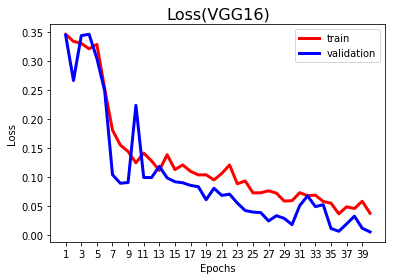

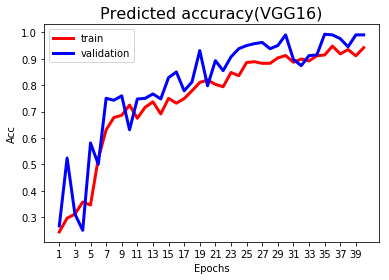

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(VGG16)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(VGG16)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])
GroundTruth:     79    77    75    77
Predicted:     79    77    75    77


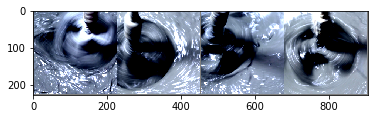

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [8]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  103	2	0	0	

Actual 77  0	104	0	1	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

